# May 9th, 2021

**Motivation**: Thorough study of InfoMap and Leiden.  Found much better way of combining data. </br>

In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    percentile: int = 20,
    min_com_size: int = 3,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            msg1 = 'pearson\n(th = {:.2f})\n'
            msg1 = msg1.format(np.min(pearson[percentile][pearson[percentile] > 0]))
            msg2 = 'spearman\n(th = {:.2f})\n'
            msg2 = msg2.format(np.min(spearman[percentile][spearman[percentile] > 0]))
            axes[0, ii].set_ylabel(msg1, fontsize=12)
            axes[1, ii].set_ylabel(msg2, fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    figsize=None,
    colorbar=False,):
    
    percentiles = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(percentiles)) if figsize is None else figsize
    fig, axes = plt.subplots(len(percentiles), 2, figsize=figsize)

    for ii, perc in enumerate(sorted(percentiles, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 0].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=12, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 1].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=12, y=1.03)
        axes[ii, 1].set_ylabel('Using {:d} {:s} \n'.format(perc, '%'), fontsize=12)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(
    organized_data: dict,
    include: Union[range, List[int]] = None,
    config: Config = None,):
    
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = list(regions.keys())[:19] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy()
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy().astype(float)
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas': atlas,
        'atlas_limited': x,
        'contour': contour,
    }
    return output

## Allen atlas visualization

In [3]:
config = Config()

subject = 6
session = 1
run = 1

load = load_organized_data(
    folder='atlas-allen_unfiltered_unnormalized',
    config=config,
    subject=subject,
    session=session,
    run=run,
)
atls_org = organize_atlas(load)

In [4]:
atls_org['regions']

{2: 'R-Primary motor area (MOp,985)',
 3: 'R-Secondary motor area (MOs,993)',
 4: 'R-Primary somatosensory area, nose (SSp-n,353)',
 5: 'R-Primary somatosensory area, barrel field (SSp-bfd,329)',
 6: 'R-Primary somatosensory area, lower limb (SSp-ll,337)',
 7: 'R-Primary somatosensory area, mouth (SSp-m,345)',
 8: 'R-Primary somatosensory area, upper limb (SSp-ul,369)',
 9: 'R-Primary somatosensory area, trunk (SSp-tr,361)',
 10: 'R-Primary somatosensory area, unassigned (SSp-un,182305689)',
 11: 'R-Supplemental somatosensory area (SSs,378)',
 14: 'R-Dorsal auditory area (AUDd,1011)',
 15: 'R-Primary auditory area (AUDp,1002)',
 16: 'R-Posterior auditory area (AUDpo,1027)',
 18: 'R-Anterolateral visual area (VISal,402)',
 19: 'R-Anteromedial visual area (VISam,394)',
 20: 'R-Lateral visual area (VISl,409)',
 21: 'R-Primary visual area (VISp,385)',
 22: 'R-Posterolateral visual area (VISpl,425)',
 23: 'R-posteromedial visual area (VISpm,533)',
 24: 'R-Anterior area (VISa,312782546)',
 2

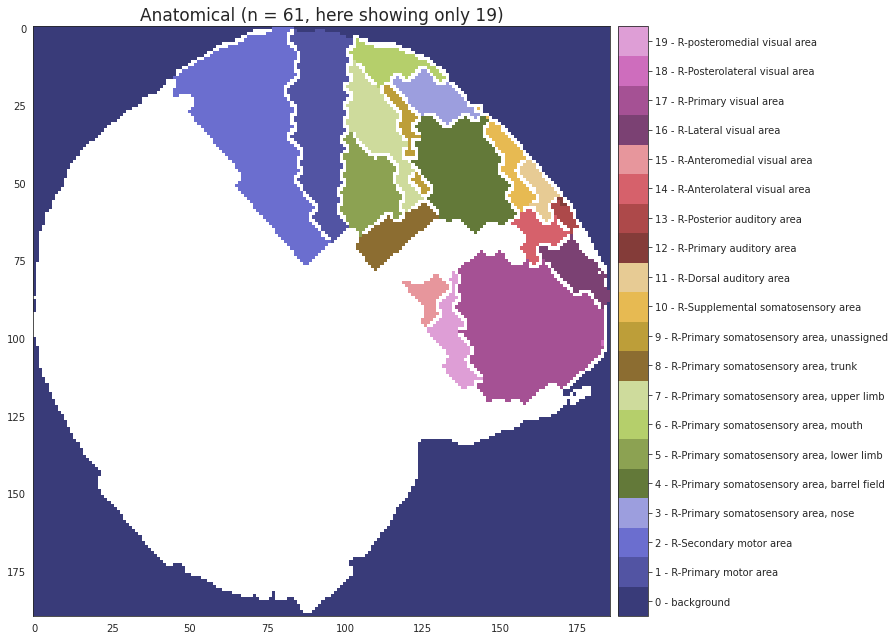

In [5]:
fig, ax = plt.subplots(figsize=(13.5, 9))
vmin = min(atls_org['mapping']) - 0.5
vmax = len(atls_org['mapping']) - 0.5
data2plt = np.ma.masked_where(atls_org['contour'], atls_org['atlas_limited'])
cax = ax.imshow(data2plt, cmap='tab20b', interpolation='none', vmin=vmin, vmax=vmax)

msg = 'Anatomical (n = {:d}, here showing only {:d})'
msg = msg.format(len(atls_org['regions']), len(atls_org['mapping']) - 1)
plt.title(msg, fontsize=17)

cbar = fig.colorbar(cax, ticks=[item for item in atls_org['mapping']], pad=0.01)
tick_labels = ['{:d} - {:s}'.format(k, v) for k, v in atls_org['mapping'].items()]
cbar.ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()

## Allen parcellation, community structure

In [6]:
data_all = {}
df = pd.DataFrame()
for run in [1, 3, 5, 7]:
    _load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    data_all[run] = _load
    
    # normalize
    mean = np.mean([item.mean() for item in _load['ca'].values()])
    sd = np.mean([item.std() for item in _load['ca'].values()])
    _ca = {k: (v - mean) / sd for k, v in _load['ca'].items()}
    _df = pd.DataFrame.from_dict(_ca)
    df = pd.concat([df, _df])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}


In [7]:
percentiles = [18, 16, 15, 13, 10, 5]
corrs = get_corrs(df, percentiles=percentiles)

In [8]:
graphs = {perc: nx.from_numpy_matrix(a) for perc, a in corrs['spearman'].items()}

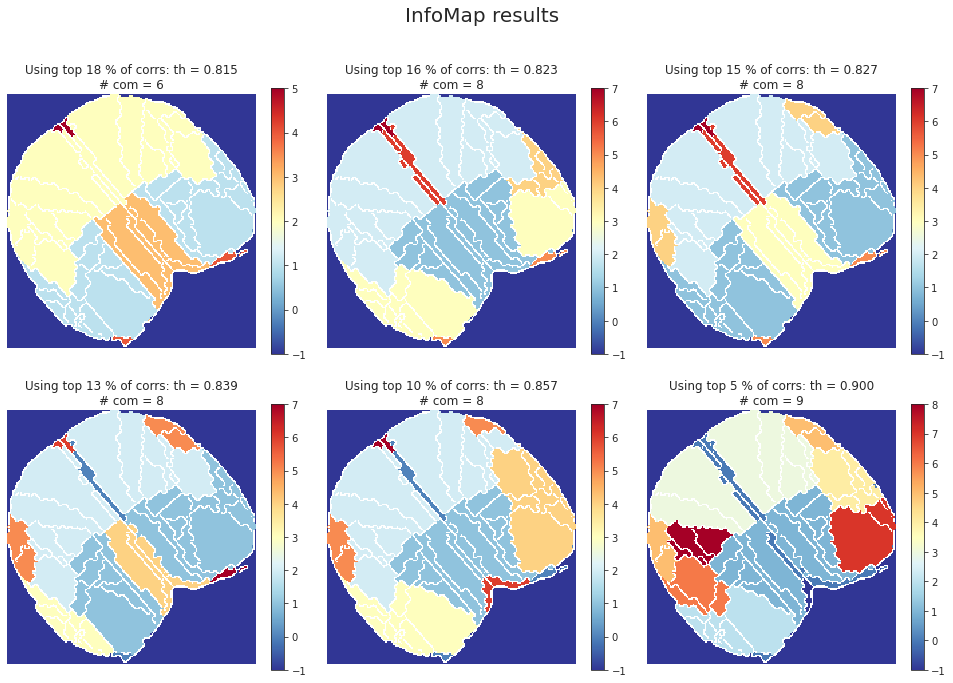

In [9]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9.5))

for idx, (perc, g) in enumerate(graphs.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\n# com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

In [10]:
results_louvain = run_louvain(graphs[13], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

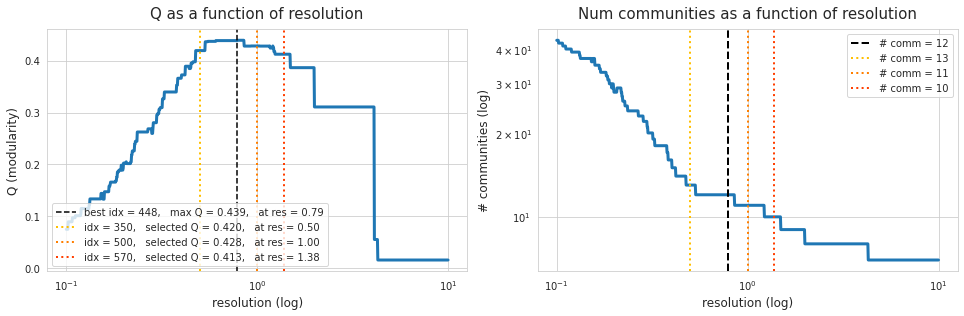

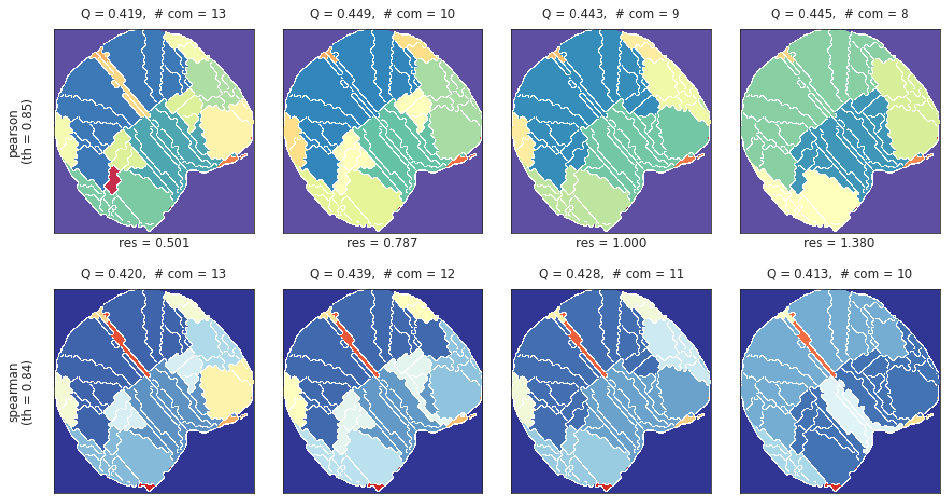

In [11]:
selected_idxs = [350, 500, 570]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    percentile=13,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

#### Leiden

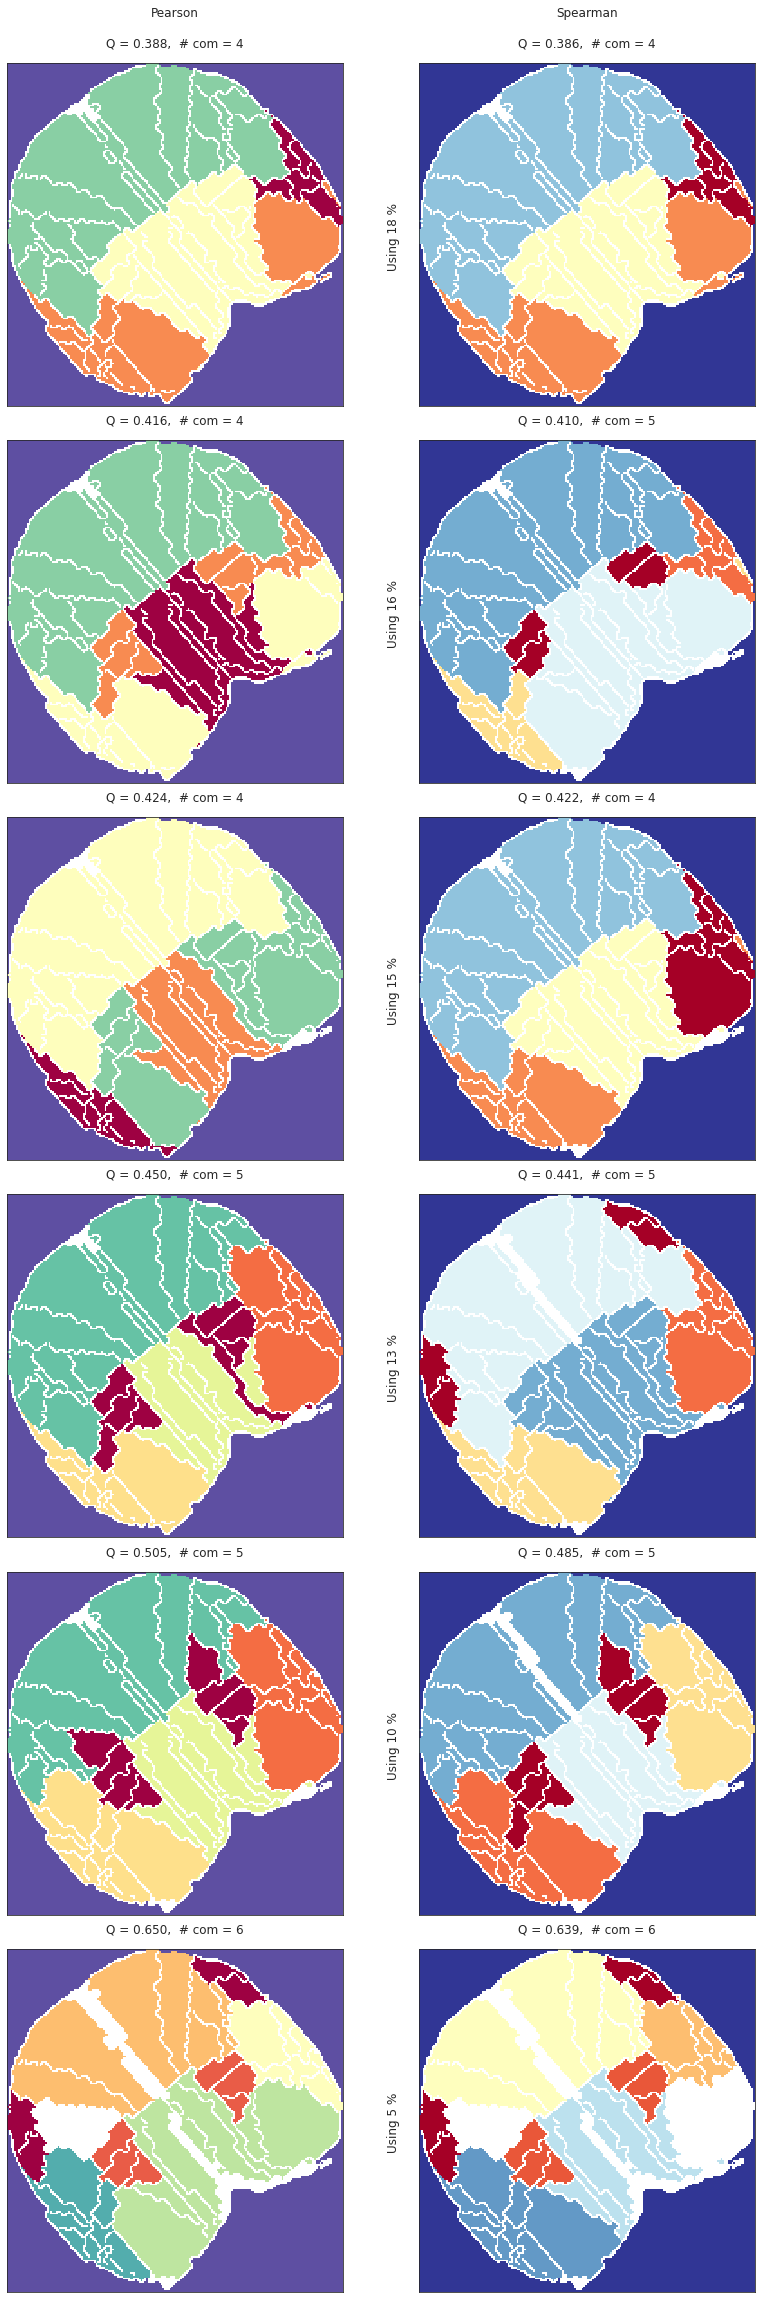

In [12]:
_ = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)

### Apply bandpass
- lowcut: 0.100 Hz
- highcut: 1.000 Hz

In [13]:
# HIDE CODE


lowcut = 0.1
highcut = 1.000
order = 2

data_all = {}
df = pd.DataFrame()
for run in [1, 3, 5, 7]:
    _load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    
    # bandpass
    ca_bp = {
        k: apply_bandpass(
            x=v,
            fs=config.ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order,
        ) for k, v in _load['ca'].items()
    }
    
    # normalize
    mean = np.mean([item.mean() for item in ca_bp.values()])
    sd = np.mean([item.std() for item in ca_bp.values()])
    ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
    data_all[run] = ca_bp_n
    
    df = pd.concat([df, pd.DataFrame.from_dict(ca_bp_n)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

In [14]:
percentiles = [20, 18, 16, 15, 13, 10]
corrs = get_corrs(df, percentiles=percentiles)
graphs = {perc: nx.from_numpy_matrix(a) for perc, a in corrs['spearman'].items()}

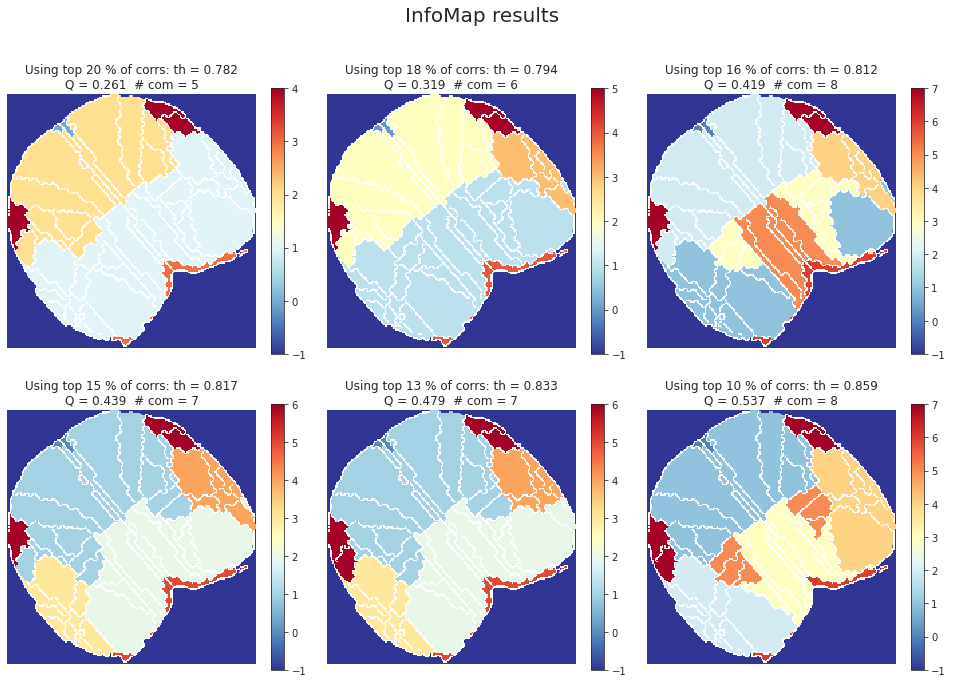

In [15]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9.5))

for idx, (perc, g) in enumerate(graphs.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    
    infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
    q = nx_comm.modularity(g, communities=infomap_community)
    
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\nQ = {:.3f}  # com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

In [16]:
results_louvain = run_louvain(graphs[13], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

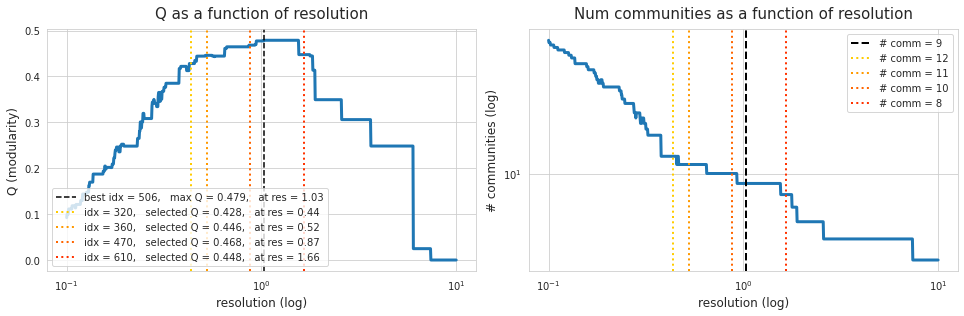

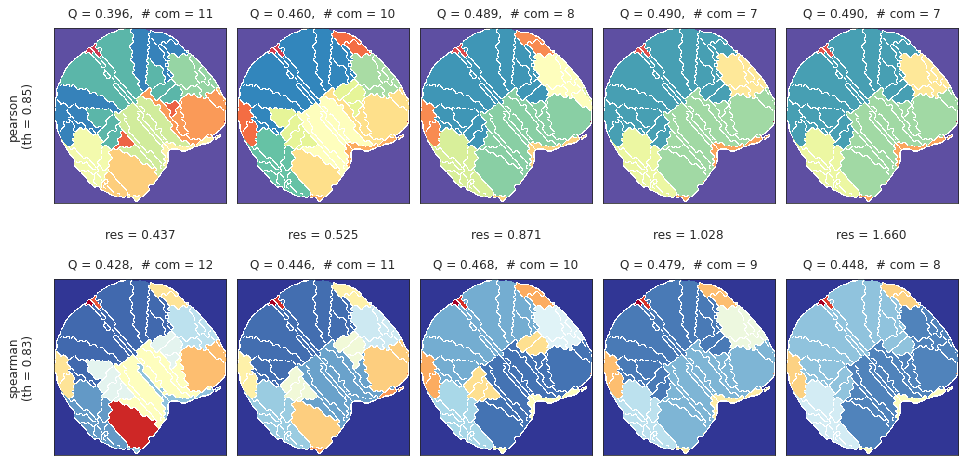

In [17]:
selected_idxs = [320, 360, 470, 610]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    percentile=13,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

#### Leiden

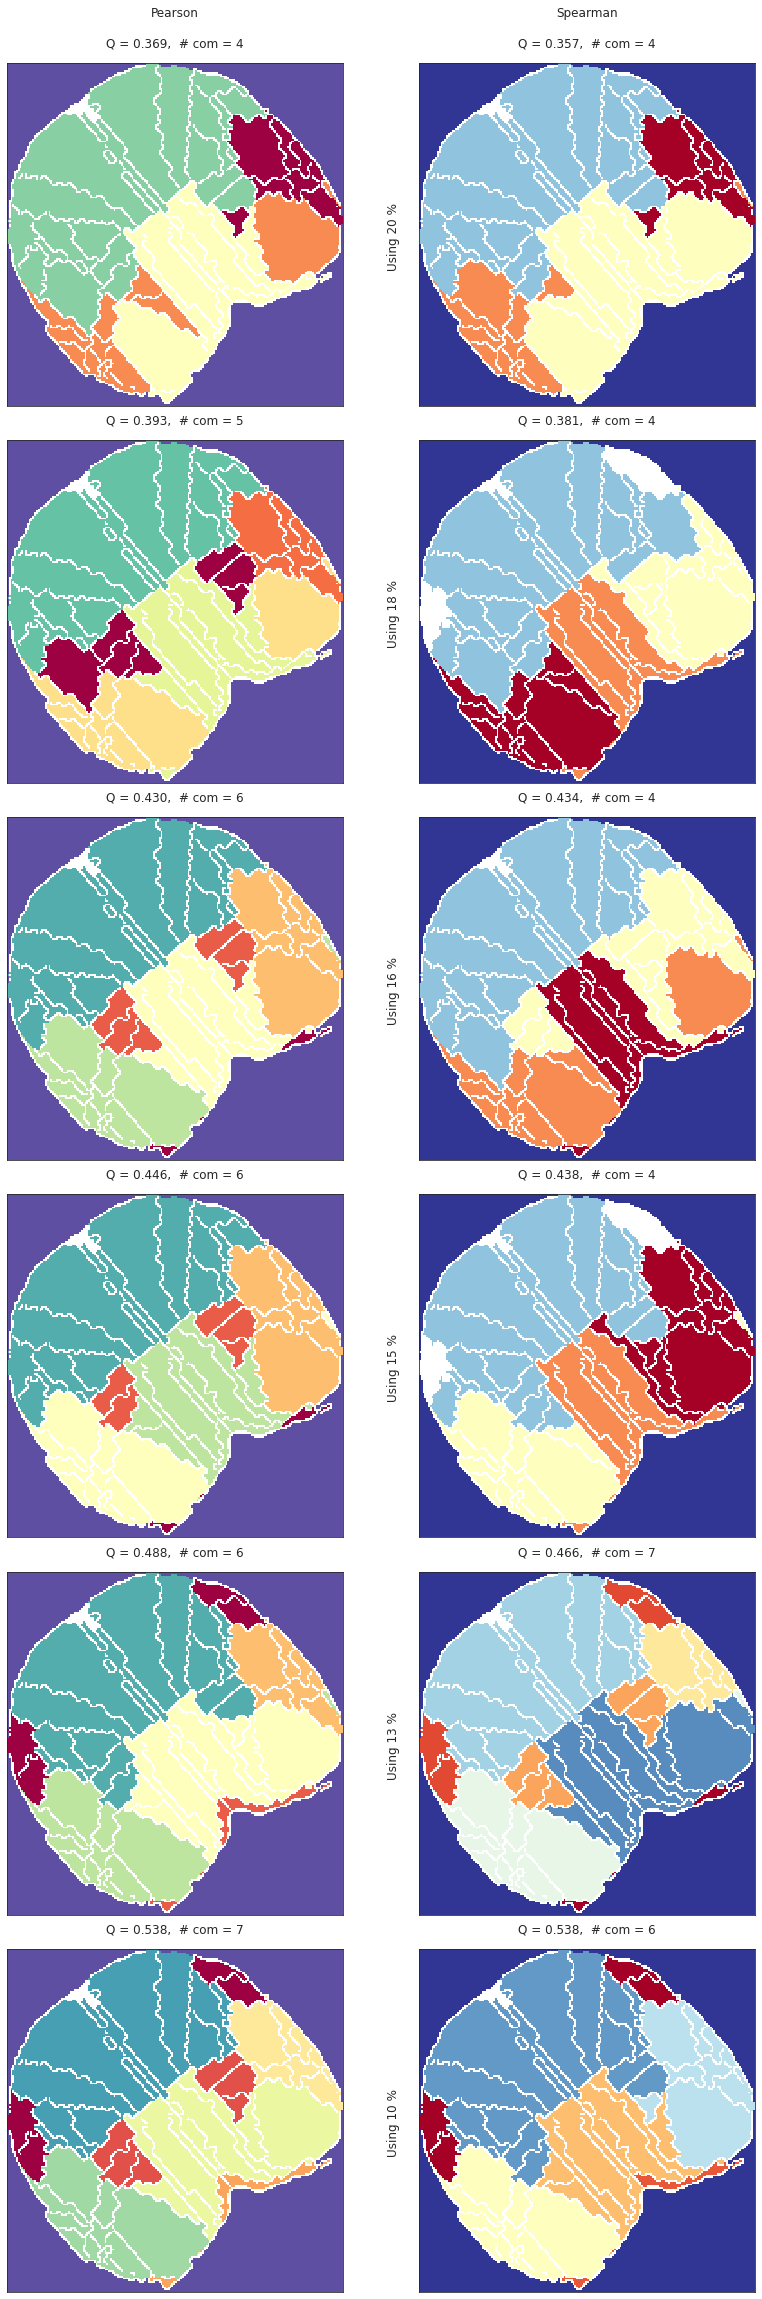

In [18]:
_ = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)

### Same, but with bandpass

In [19]:
# HIDE CODE


lowcut = 0.1
highcut = 1.0

df = pd.DataFrame()
df_n = pd.DataFrame()

for subject in tqdm(range(1, config.num_subjects+1)):
    for session in range(1, config.num_sessions+1):
        for run in [1, 3, 5, 7]:
            cond_1 = subject == 3 and session == 2 and run in [2, 6]
            cond_2 = subject == 7 and session == 2 and run in [2, 7]
            if cond_1 or cond_2:
                continue

            _load = load_organized_data(
                folder='atlas-allen_unfiltered_unnormalized',
                config=config,
                subject=subject,
                session=session,
                run=run,
            )
            if _load is None:
                continue

            for k, v in _load['ca'].items():
                if np.isnan(v).sum():
                    print(session, run, k)

            # bandpass
            if lowcut is None or highcut is None:
                ca_bp = {k: v for k, v in _load['ca'].items()}
            else:
                ca_bp = {
                    k: apply_bandpass(
                        x=v,
                        fs=config.ca_fs,
                        lowcut=lowcut,
                        highcut=highcut,
                        order=order, )
                    for k, v in _load['ca'].items()
                }

            # normalize
            mean = np.mean([item.mean() for item in ca_bp.values()])
            sd = np.mean([item.std() for item in ca_bp.values()])
            ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}

            # put in df
            df = pd.concat([df, pd.DataFrame.from_dict(ca_bp)])
            df_n = pd.concat([df_n, pd.DataFrame.from_dict(ca_bp_n)])

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
run = 1
regions = {}
tot_num_regions = {}
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )
        if _load is None:
            continue
        _atlsorg = organize_atlas(_load)
        key = 'sub-SLC{:02d}_ses-{:d}'.format(subject, session)
        regions[key] = _atlsorg['regions']
        tot_num_regions[key] = len(_atlsorg['regions'])

common_regions = list(set.intersection(*[set(reg_dict.keys()) for reg_dict in regions.values()]))
len(common_regions)

46

In [21]:
df = df.loc[:, common_regions]
df_n = df_n.loc[:, common_regions]

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

In [22]:
percentiles = [25, 20, 18, 15, 13, 10]

corrs = get_corrs(df, percentiles=percentiles)
corrs_n = get_corrs(df_n, percentiles=percentiles)

In [23]:
graphs = {perc: nx.from_numpy_matrix(a) for perc, a in corrs['pearson'].items()}
graphs_n = {perc: nx.from_numpy_matrix(a) for perc, a in corrs_n['pearson'].items()}

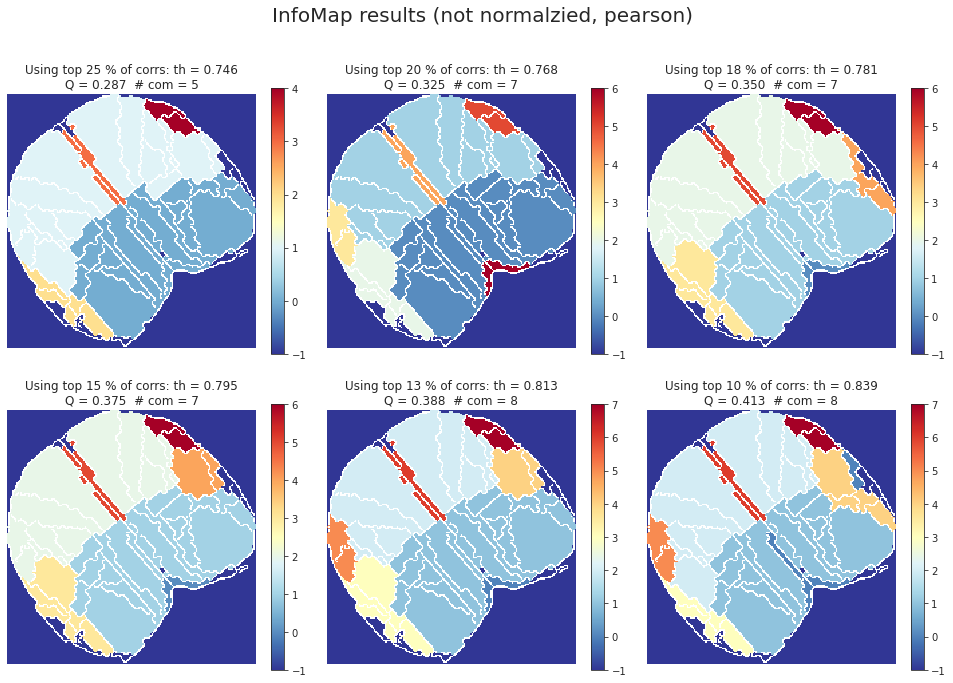

In [24]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9.5))

for idx, (perc, g) in enumerate(graphs.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    
    infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
    q = nx_comm.modularity(g, communities=infomap_community)
    
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\nQ = {:.3f}  # com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results (not normalzied, pearson)', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

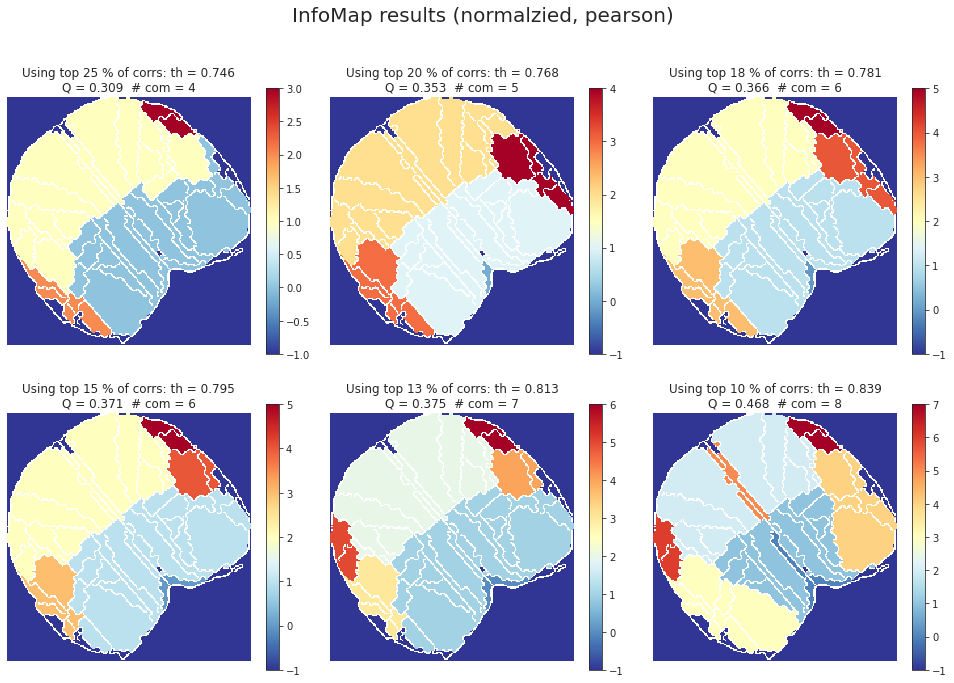

In [25]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9.5))

for idx, (perc, g) in enumerate(graphs_n.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    
    infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
    q = nx_comm.modularity(g, communities=infomap_community)
    
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\nQ = {:.3f}  # com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results (normalzied, pearson)', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

In [26]:
graphs = {perc: nx.from_numpy_matrix(a) for perc, a in corrs['spearman'].items()}
graphs_n = {perc: nx.from_numpy_matrix(a) for perc, a in corrs_n['spearman'].items()}

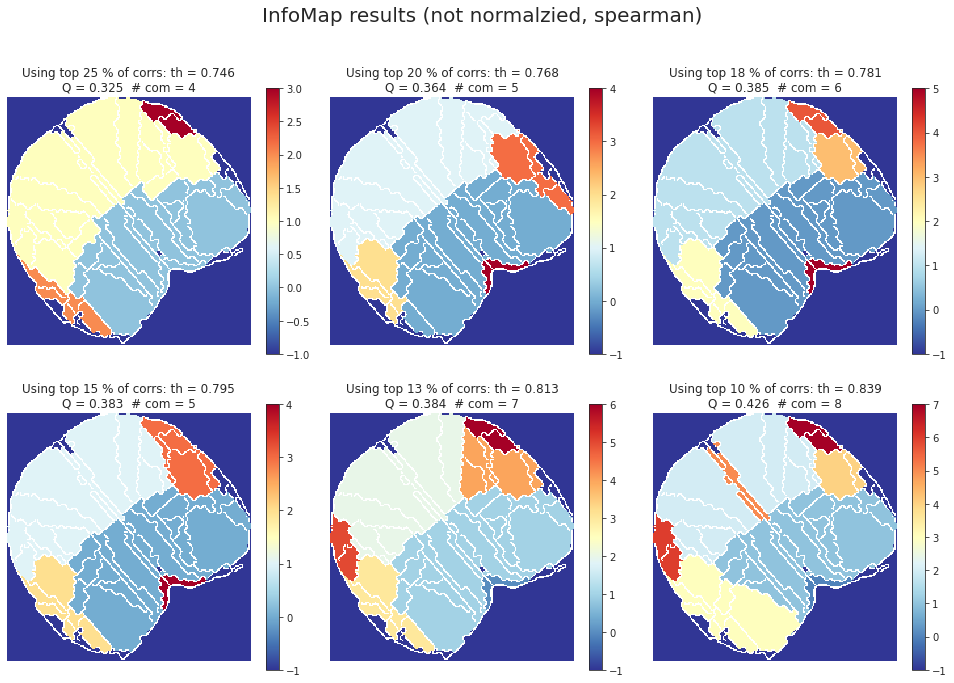

In [27]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9.5))

for idx, (perc, g) in enumerate(graphs.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    
    infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
    q = nx_comm.modularity(g, communities=infomap_community)
    
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\nQ = {:.3f}  # com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results (not normalzied, spearman)', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

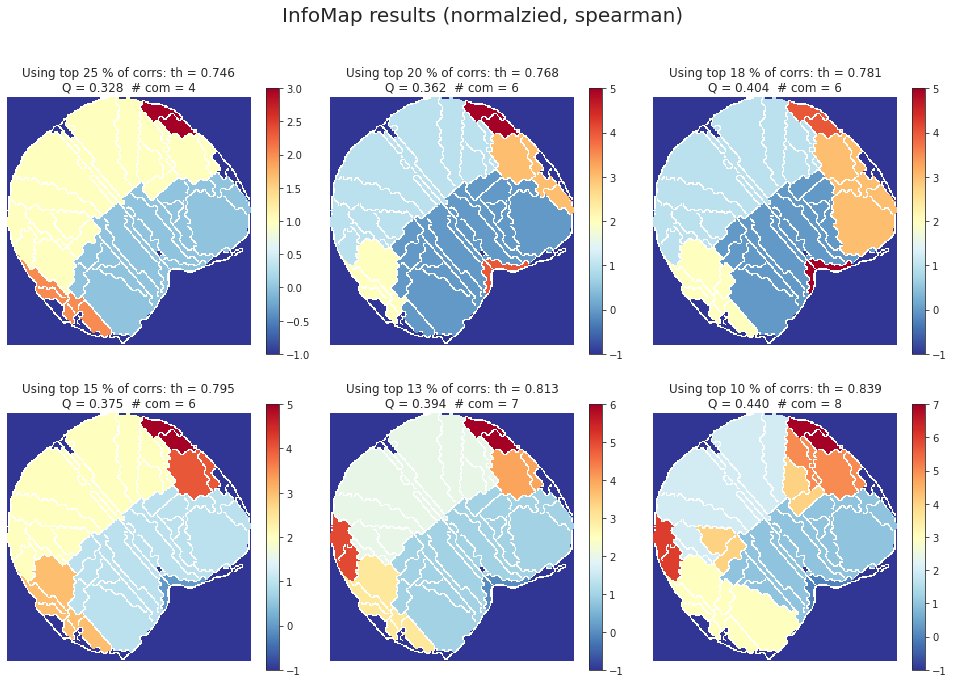

In [28]:
# HIDE CODE


sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 9.5))

for idx, (perc, g) in enumerate(graphs_n.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    
    infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
    q = nx_comm.modularity(g, communities=infomap_community)
    
    msg = 'Using top {:d} {:s} of corrs: th = {:.3f}\nQ = {:.3f}  # com = {:d}'
    msg = msg.format(
        perc, '%', np.min(corrs['spearman'][perc][corrs['spearman'][perc] > 0]),
        q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])),
    )
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results (normalzied, spearman)', fontsize=20, y=1.02)
fig.tight_layout()    
plt.show()

In [29]:
results_louvain = run_louvain(graphs_n[13], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

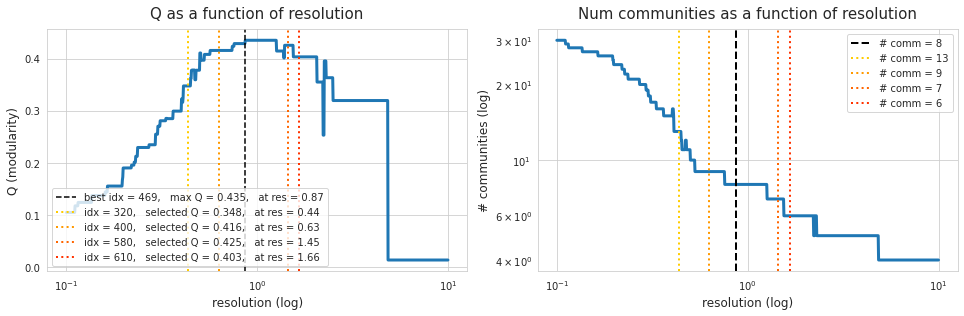

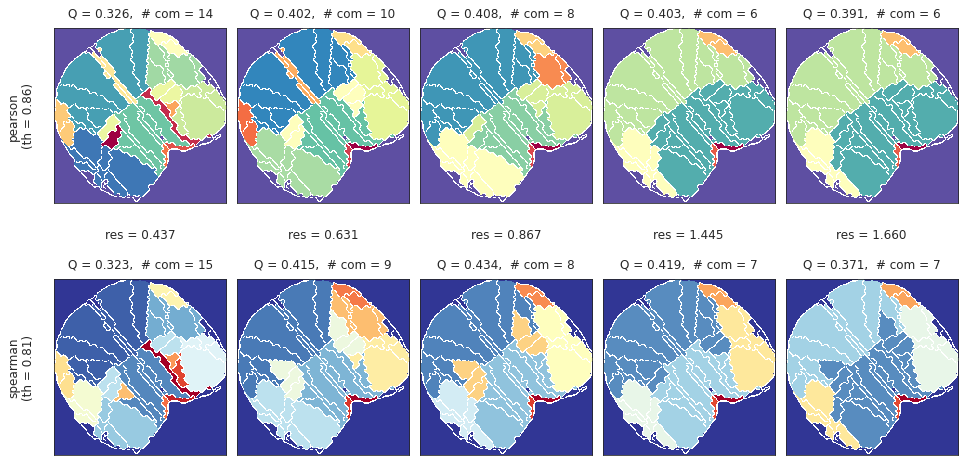

In [30]:
selected_idxs = [320, 400, 580, 610]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    percentile=13,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

#### Leiden

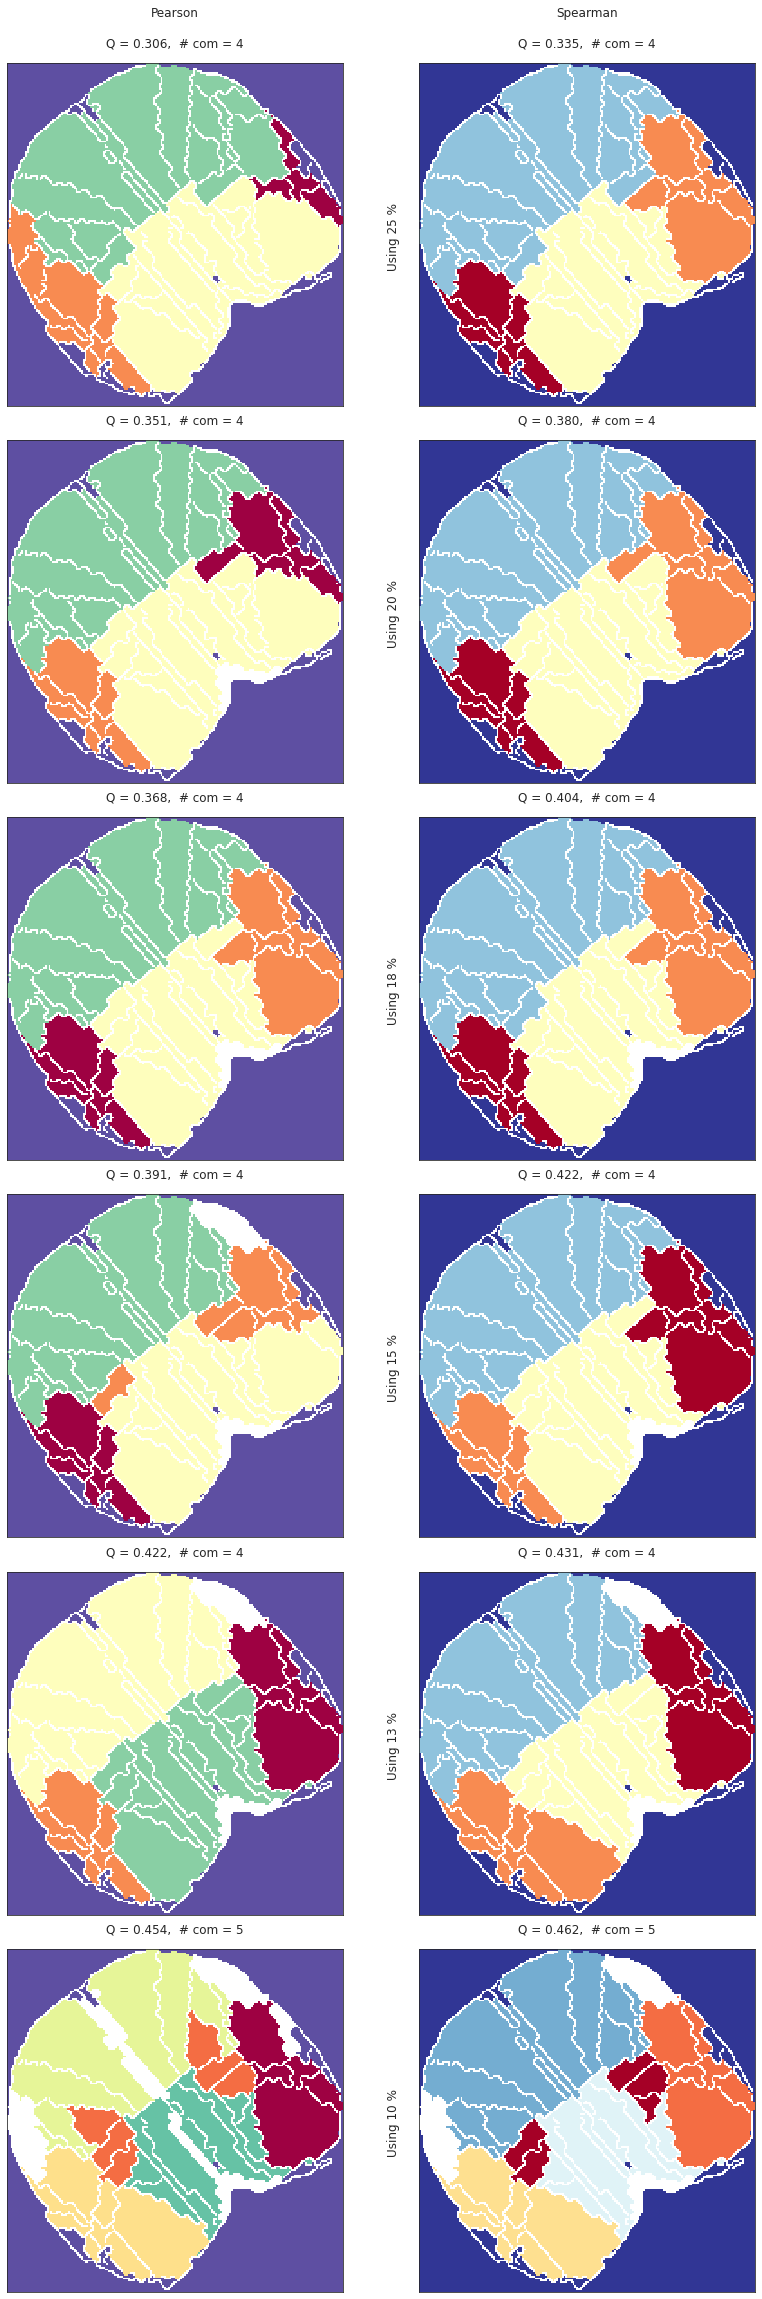

In [31]:
_ = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)

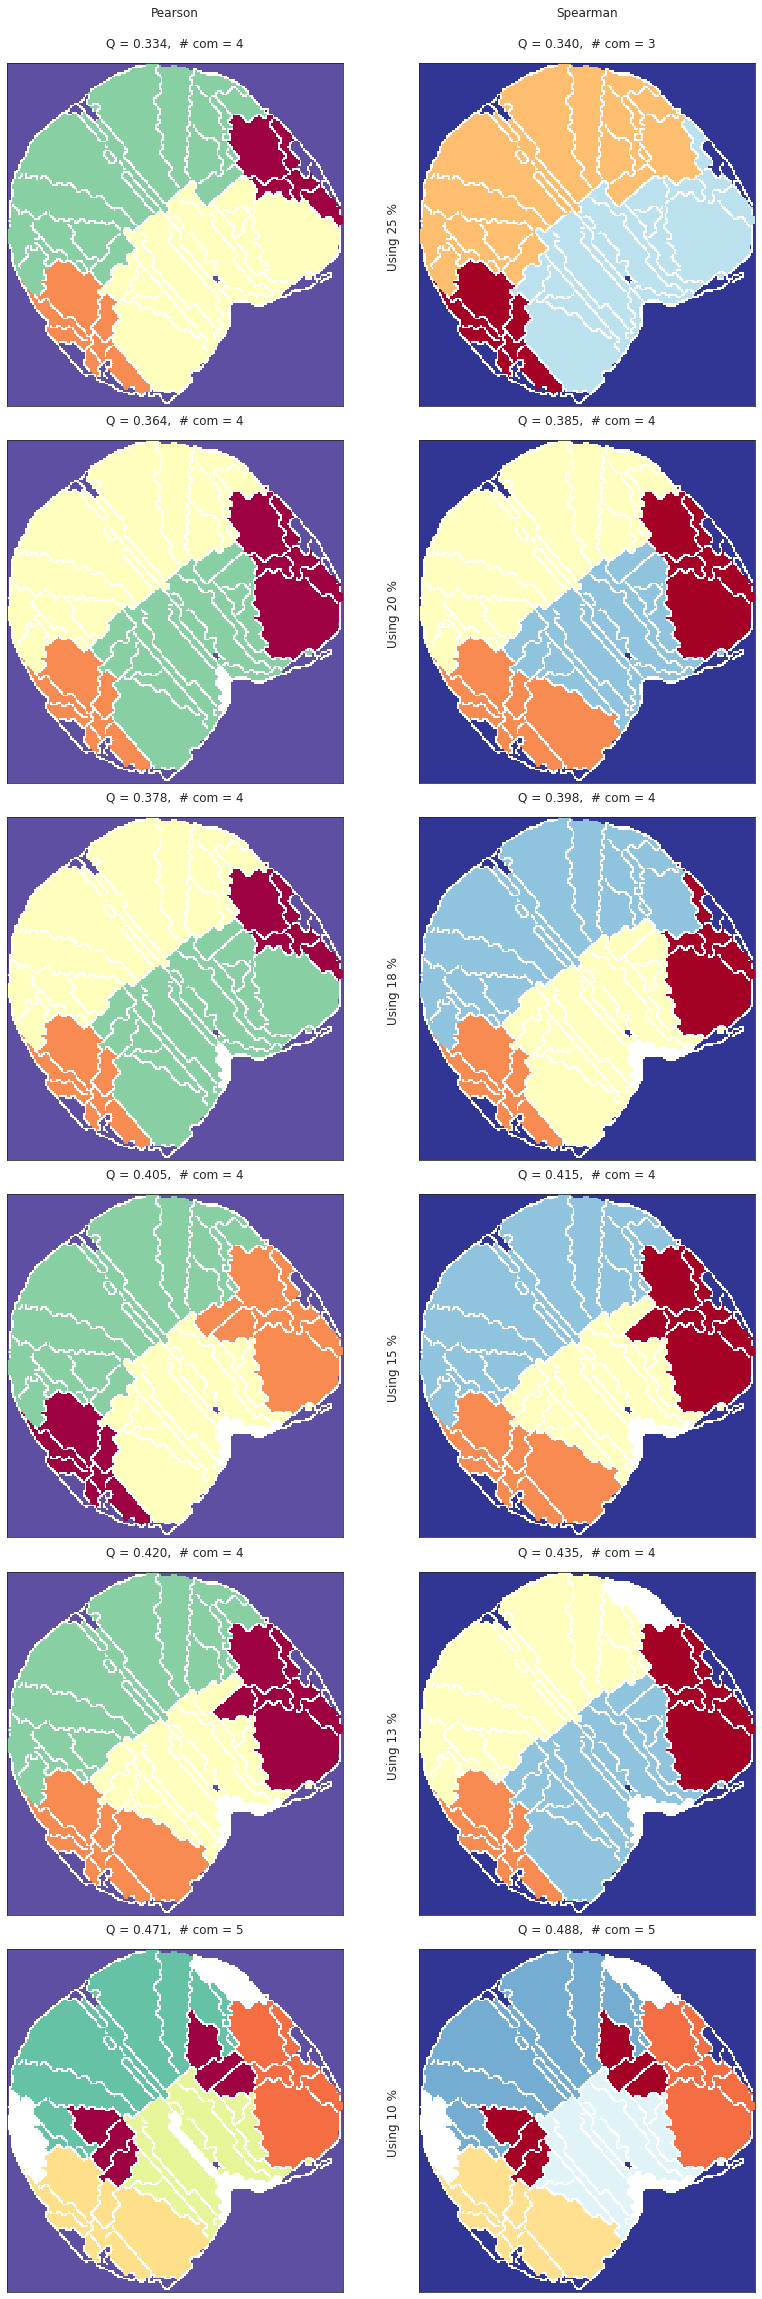

In [32]:
_ = plot_leiden_communities(
    pearson=corrs_n['pearson'],
    spearman=corrs_n['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)

## COMBINE DATA

In [33]:
run = 1
regions = {}
tot_num_regions = {}
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )
        if _load is None:
            continue
        _atlsorg = organize_atlas(_load)
        key = 'sub-SLC{:02d}_ses-{:d}'.format(subject, session)
        regions[key] = _atlsorg['regions']
        tot_num_regions[key] = len(_atlsorg['regions'])

common_regions = list(set.intersection(*[set(reg_dict.keys()) for reg_dict in regions.values()]))
common_regions = {k: config.region_labels[k] for k in sorted(common_regions)}
common_r = [item[2:] for item in common_regions.values() if item[:2] == 'R-']
common_l = [item[2:] for item in common_regions.values() if item[:2] == 'L-']
common_global = set(common_r).intersection(common_l)
common_regions = {k: v for k, v in common_regions.items() if v[2:] in common_global}
len(common_regions)

44

In [34]:
field_names = ('mode', 'subject', 'session', 'run', 'norm', 'df')
MouseDF = collections.namedtuple(typename='MouseDF', field_names=field_names)

field_names = ('mode', 'subject', 'session', 'run', 'norm', 'percentile', 'node_labels', 'a', 'g', 'cfg')
MouseGraph = collections.namedtuple(typename='MouseGraph', field_names=field_names)

### Get MouseDF

In [35]:
# HIDE CODE


lowcut = None
highcut = None
mode = 'ca'
df_all = {}

for subject in tqdm(range(1, config.num_subjects+1)):
    for session in range(1, config.num_sessions+1):
        for run in [1, 3, 5, 7]:
            cond_1 = subject == 3 and session == 2 and run in [2, 6]
            cond_2 = subject == 7 and session == 2 and run in [2, 7]
            if cond_1 or cond_2:
                continue

            _load = load_organized_data(
                folder='atlas-allen_unfiltered_unnormalized',
                config=config,
                subject=subject,
                session=session,
                run=run,
            )
            if _load is None:
                continue

            for k, v in _load['ca'].items():
                if np.isnan(v).sum():
                    print(subject, session, run, k)

            # bandpass
            if lowcut is None or highcut is None:
                ca_bp = {k: v for k, v in _load['ca'].items()}
            else:
                ca_bp = {
                    k: apply_bandpass(
                        x=v,
                        fs=config.ca_fs,
                        lowcut=lowcut,
                        highcut=highcut,
                        order=order, )
                    for k, v in _load['ca'].items()
                }

            # normalize
            mean = np.mean([item.mean() for item in ca_bp.values()])
            sd = np.mean([item.std() for item in ca_bp.values()])
            ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
            
            key = 'mode-{:s}_sub-SLC{:02d}'.format(mode, subject)
            key += '_ses-{:d}'.format(session)
            key += '_run-{:d}'.format(run)

            for norm in [1, 0]:
                df = pd.DataFrame.from_dict(ca_bp_n) if norm else pd.DataFrame.from_dict(ca_bp)
                df = df.loc[:, common_regions.keys()]
                new_key = '{:s}_norm-{:s}'.format(key, str(norm))

                df_all[new_key] = MouseDF(
                    mode=mode,
                    subject=subject,
                    session=session,
                    run=run,
                    norm=norm,
                    df=df,
                )

  0%|          | 0/10 [00:00<?, ?it/s]

### Now combine MouseDF to get MouseGraph

In [36]:
def df2graph(
    df: pd.DataFrame,
    percentiles: List[int],
    corr_mode: str = 'pearson', ):
    
    node_labels = {i: lbl for i, lbl in enumerate(df.columns.values.tolist())}
    corrs = get_corrs(df, percentiles=percentiles)

    output = {}
    for perc, a in corrs[corr_mode].items():
        g = nx.from_numpy_matrix(a)
        output[perc] = (node_labels, a, g, mk_config_model(g, weighted=True))

    return output

In [37]:
# HIDE CODE


mode = 'ca'
norm = 1
percentiles = [30, 25, 20, 15, 10]

key_global = 'mode-{:s}'.format(mode)
df_global = pd.DataFrame()
graph_all = {}
for subject in tqdm(range(1, config.num_subjects+1)):
    key_subject = '{:s}_sub-SLC{:02d}'.format(key_global, subject)
    df_subject = pd.DataFrame()
    for session in tqdm(range(1, config.num_sessions+1), leave=False):
        key_session = '{:s}_ses-{:d}'.format(key_subject, session)
        df_session = pd.DataFrame()
        for run in [1, 3, 5, 7]:
            key_run = '{:s}_run-{:d}'.format(key_session, run)
            tmp_key = '{:s}_norm-{:s}'.format(key_run, str(norm))
            try:
                df_run = df_all[tmp_key].df
            except KeyError:
                continue
            
            # do df_run
            output = df2graph(df_run, percentiles)
            for perc, (node_labels, a, g, cfg) in output.items():
                graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
                    mode=mode,
                    subject=subject,
                    session=session,
                    run=run,
                    norm=norm,
                    percentile=perc,
                    node_labels=node_labels,
                    a=a,
                    g=g,
                    cfg=cfg,
                )
            # concat run -> session
            df_session = pd.concat([df_session, df_run])

        # do df_session
        tmp_key = '{:s}_norm-{:s}'.format(key_session, str(norm))
        output = df2graph(df_session, percentiles)
        for perc, (node_labels, a, g, cfg) in output.items():
            graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
                mode=mode,
                subject=subject,
                session=session,
                run=-1,
                norm=norm,
                percentile=perc,
                node_labels=node_labels,
                a=a,
                g=g,
                cfg=cfg,
            )
        # concat session -> subject
        df_subject = pd.concat([df_subject, df_session])
        
    # do df_subject
    tmp_key = '{:s}_norm-{:s}'.format(key_subject, str(norm))
    output = df2graph(df_subject, percentiles)
    for perc, (node_labels, a, g, cfg) in output.items():
        graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
            mode=mode,
            subject=subject,
            session=-1,
            run=-1,
            norm=norm,
            percentile=perc,
            node_labels=node_labels,
            a=a,
            g=g,
            cfg=cfg,
        )
    # concat subject -> global
    df_global = pd.concat([df_global, df_subject])
     
# do df_global
tmp_key = '{:s}_norm-{:s}'.format(key_global, str(norm))
output = df2graph(df_global, percentiles)
for perc, (node_labels, a, g, cfg) in output.items():
    graph_all[tmp_key + '_perc-{:d}'.format(perc)] = MouseGraph(
        mode=mode,
        subject=-1,
        session=-1,
        run=-1,
        norm=norm,
        percentile=perc,
        node_labels=node_labels,
        a=a,
        g=g,
        cfg=cfg,
    )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### Results: 3 x sessions, 10 x subjects

#### InfoMap

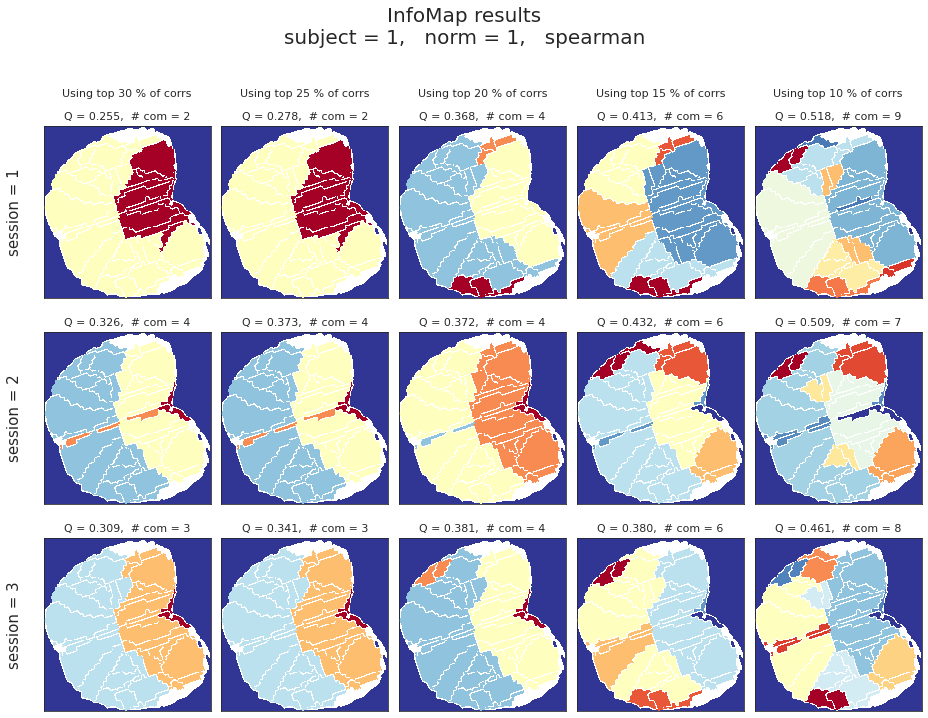

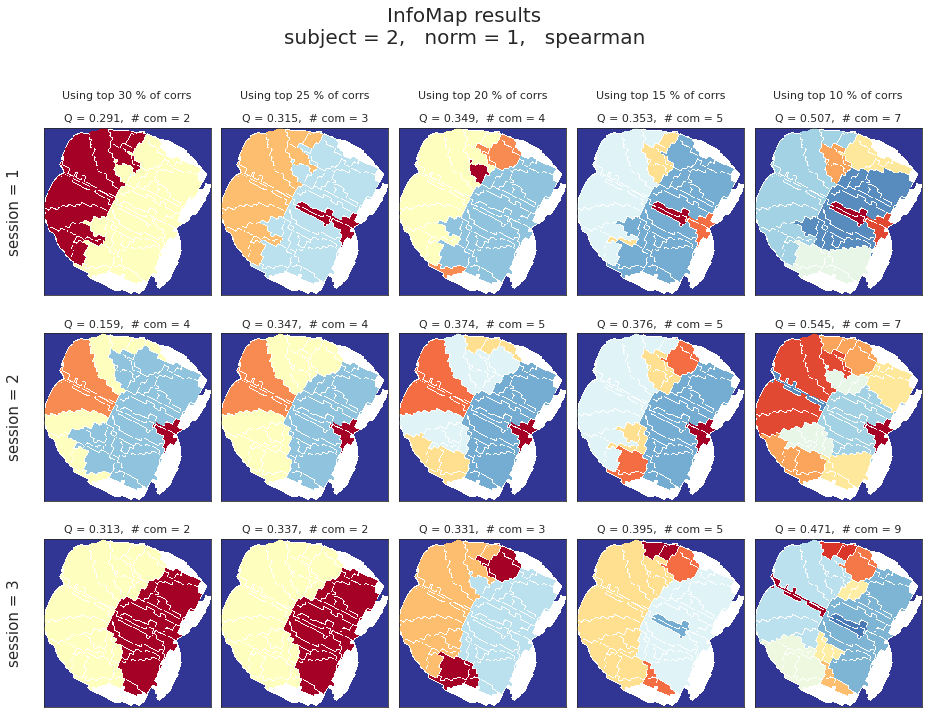

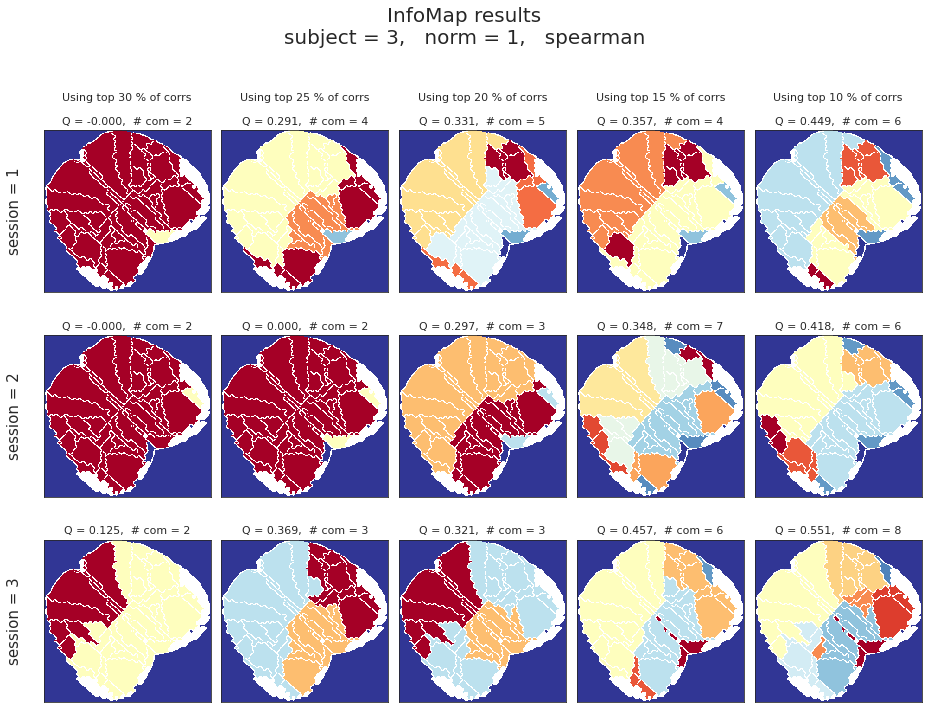

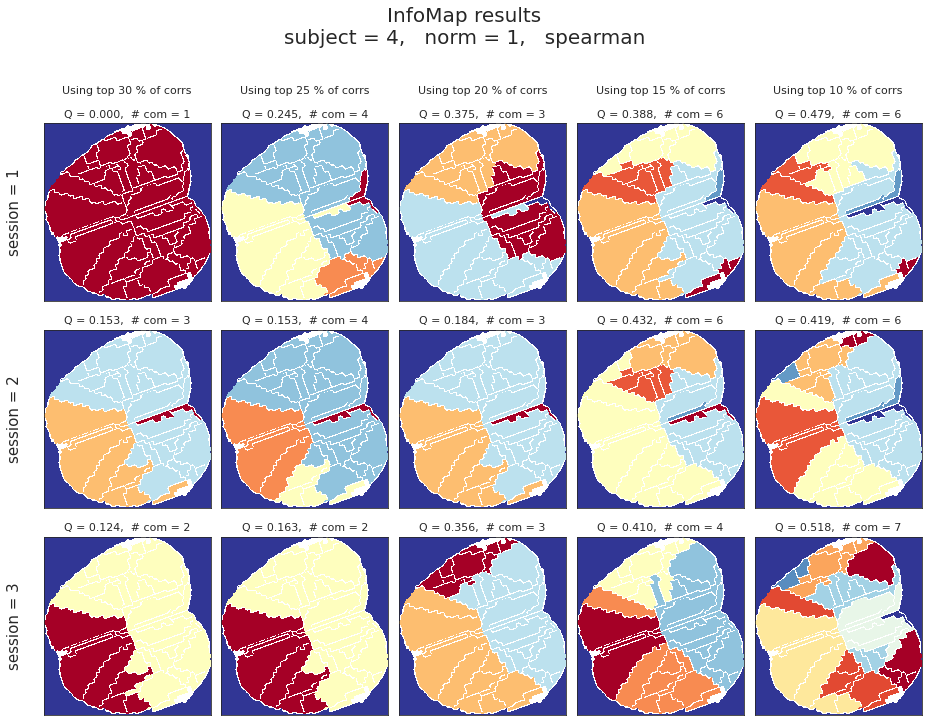

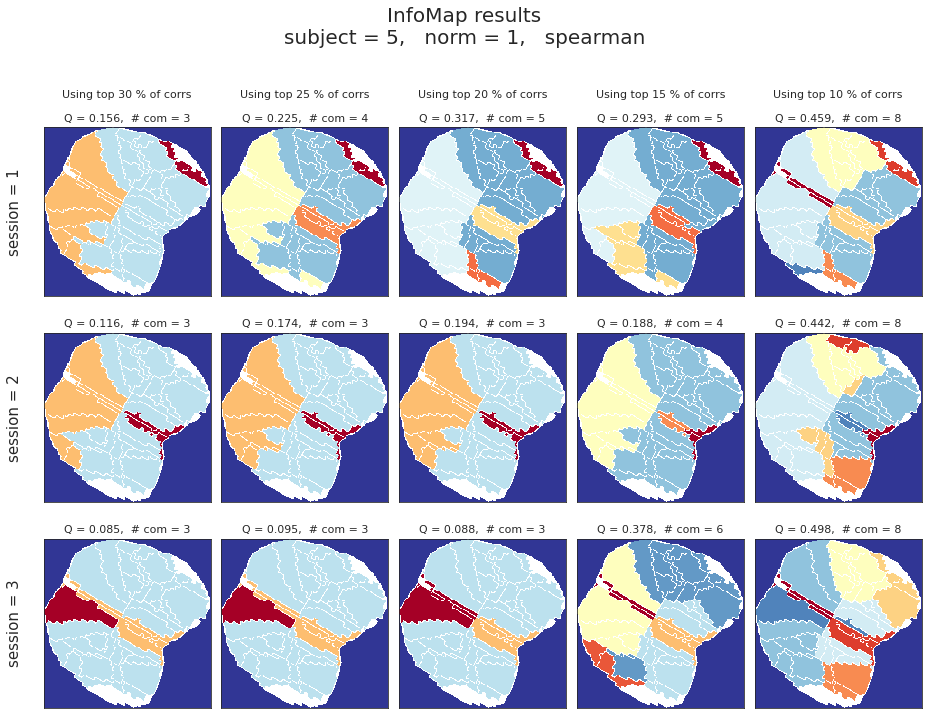

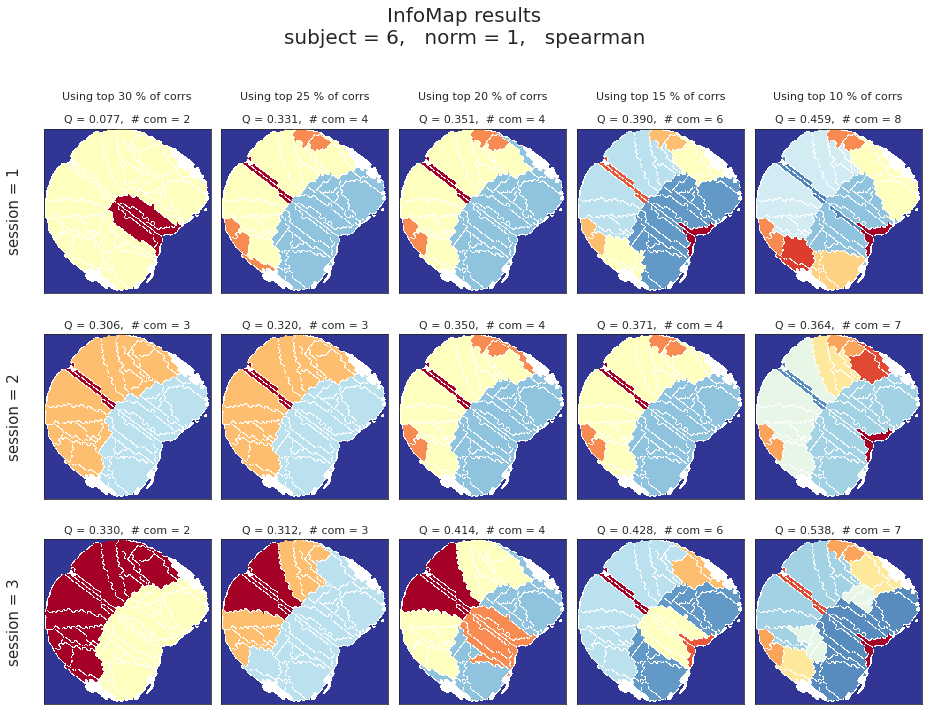

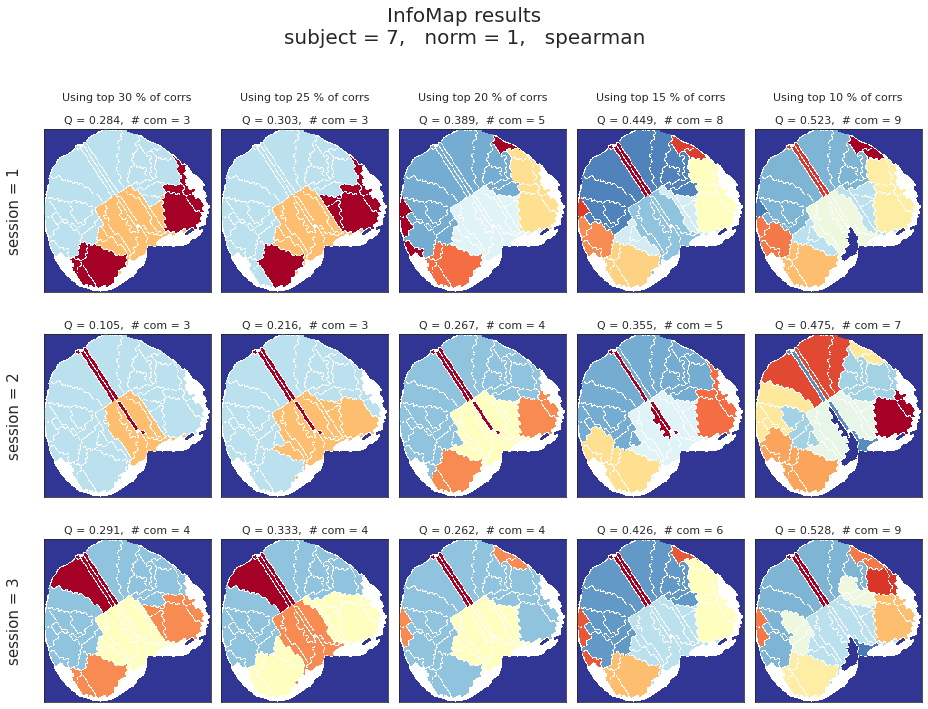

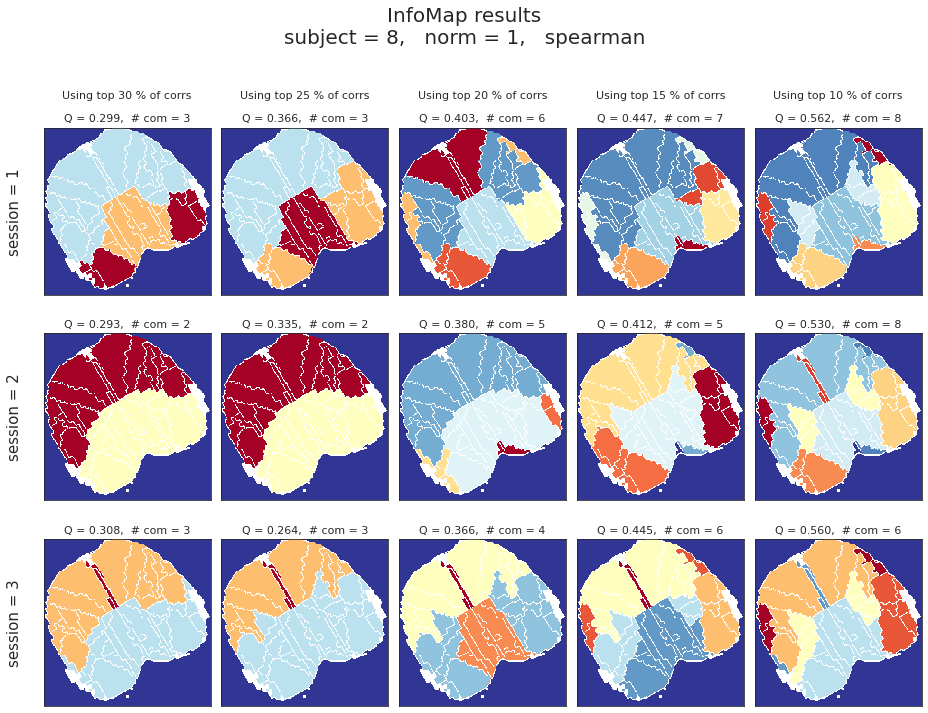

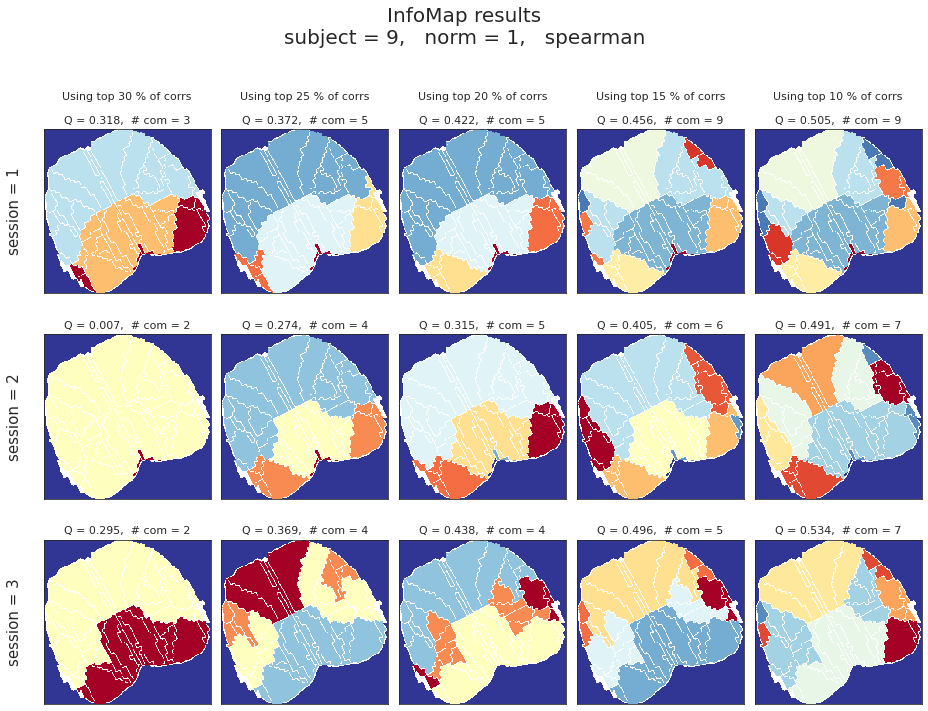

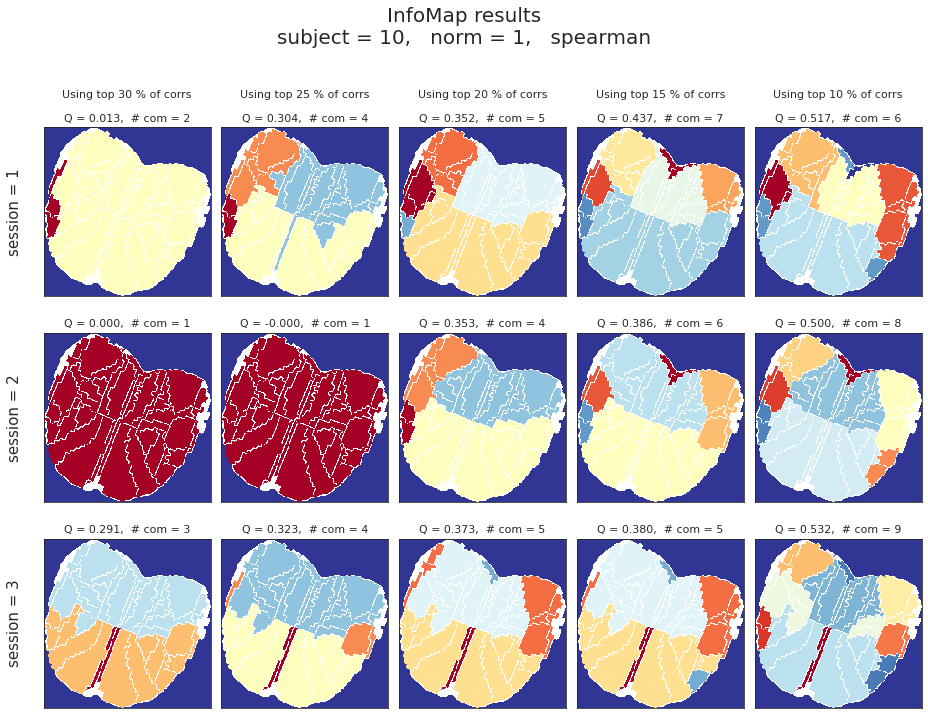

In [39]:
# HIDE CODE


config = Config()

for subject in range(1, config.num_subjects+1):
    session = 2
    run = 1

    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    sns.set_style('white')
    nrows, ncols = 3, len(percentiles)
    fig, axes = plt.subplots(nrows, ncols, figsize=(13, 10))
    axes = axes.reshape(nrows, ncols)

    for i, session in enumerate([1, 2, 3]):
        key = 'mode-{:s}_sub-SLC{:02d}_ses-{:d}_norm-{:s}'
        key = key.format(mode, subject, session, str(norm))
        for j, perc in enumerate(percentiles):
            tmp_key = '{:s}_perc-{:d}'.format(key, perc)
            try:
                data = graph_all[tmp_key]
            except KeyError:
                continue

            node_labels = data.node_labels
            g = data.g

            infomap_coms = cdlib_algorithms.infomap(g)
            infomap_community = infomap_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
            infomap_partition = convert('community', 'partition', community=infomap_community)
            output = filter_islands(infomap_partition, atls_org['atlas'], node_labels, min_com_size=0)

            infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
            q = nx_comm.modularity(g, communities=infomap_community)

            if i == 0:
                msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
            else:
                msg = ''
            msg += 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

            data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
            im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
            axes[i, j].set_title(msg, fontsize=11)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if j == 0:
                axes[i, j].set_ylabel('session = {:d}\n'.format(session), fontsize=15)

    msg = 'InfoMap results\nsubject = {:d},   norm = {:s},   spearman'
    sup = fig.suptitle(msg.format(subject, str(norm)), fontsize=20, y=1.02)
    fig.tight_layout()    
    plt.show()

    print('\n\n')

#### Leiden

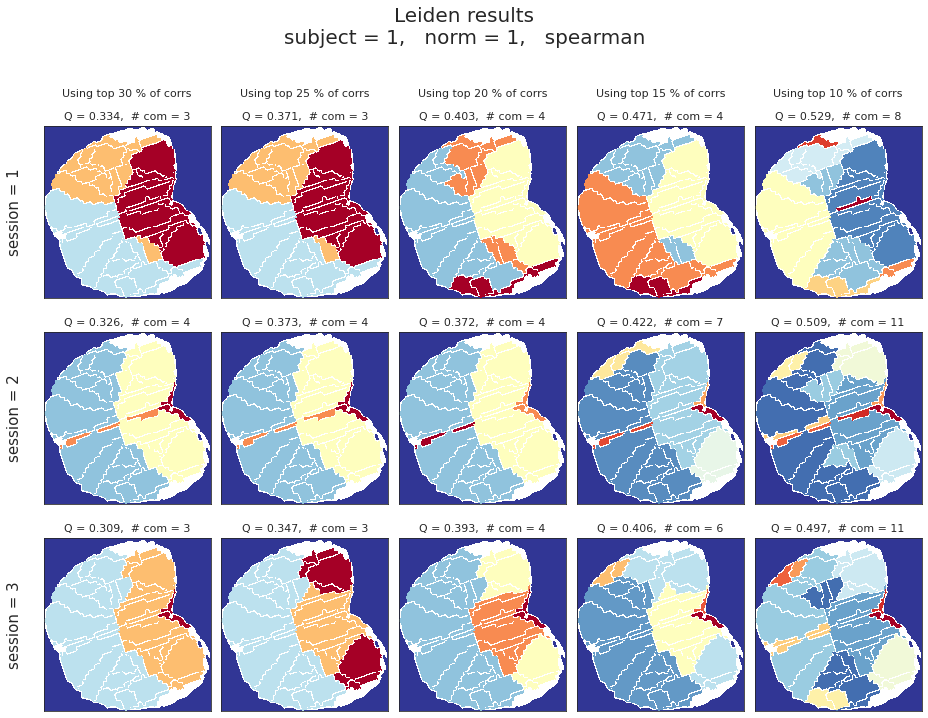

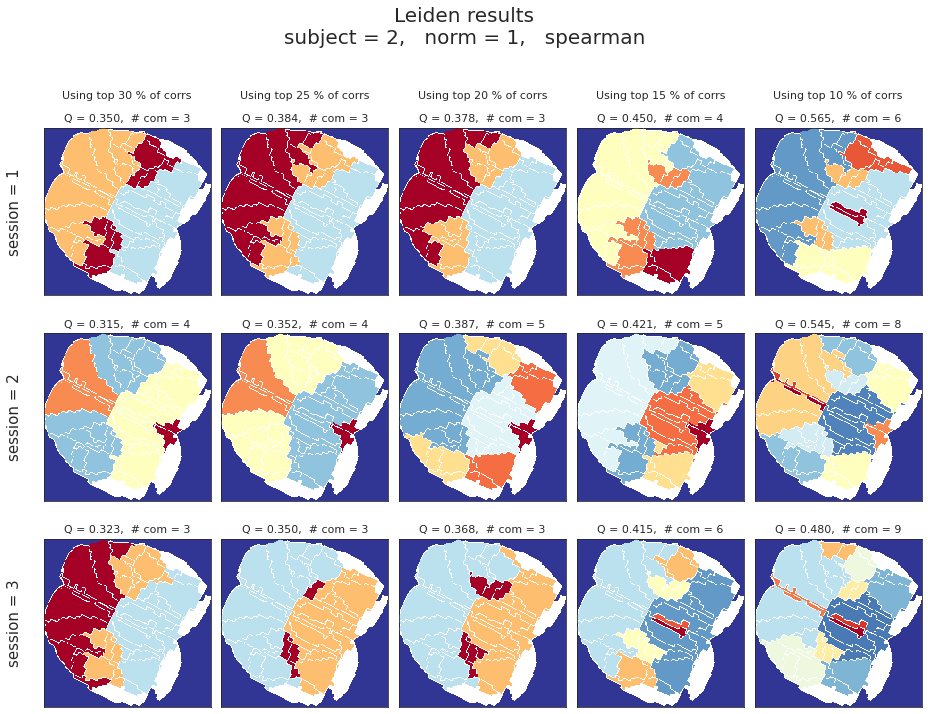

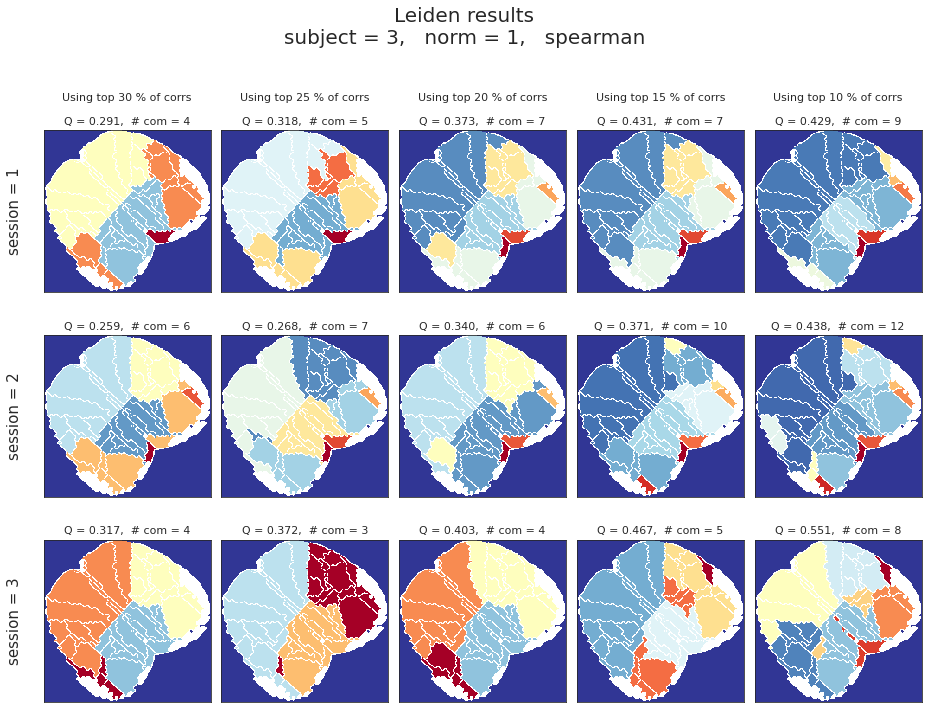

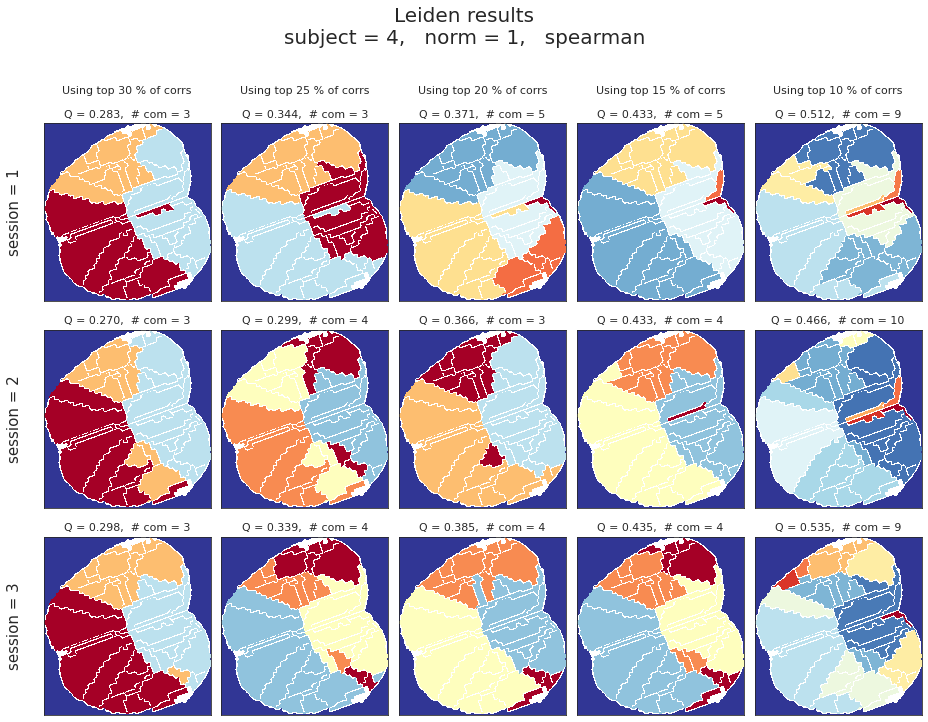

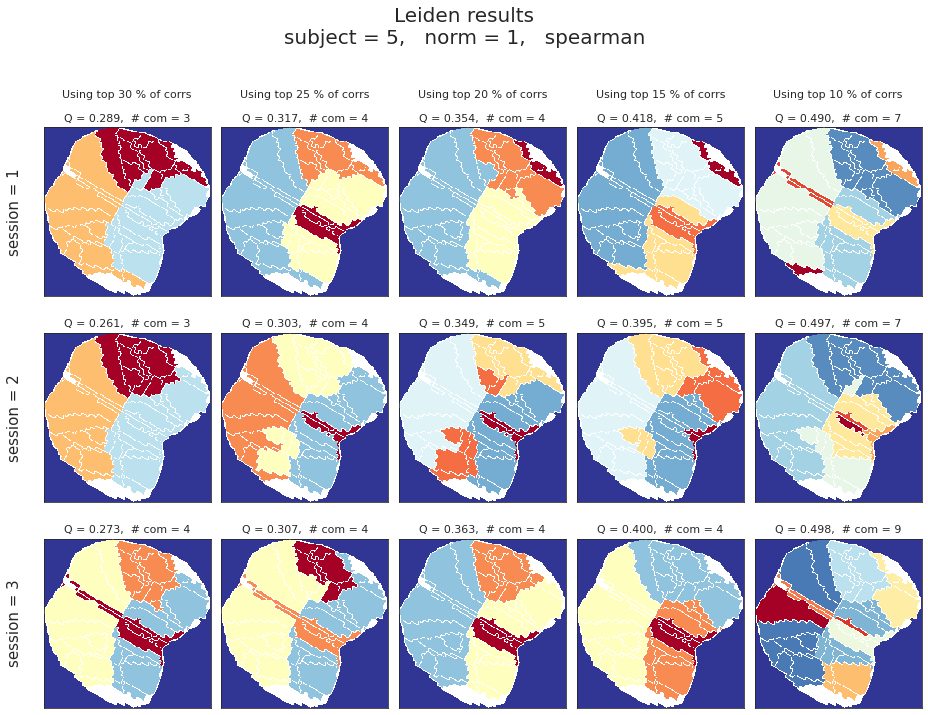

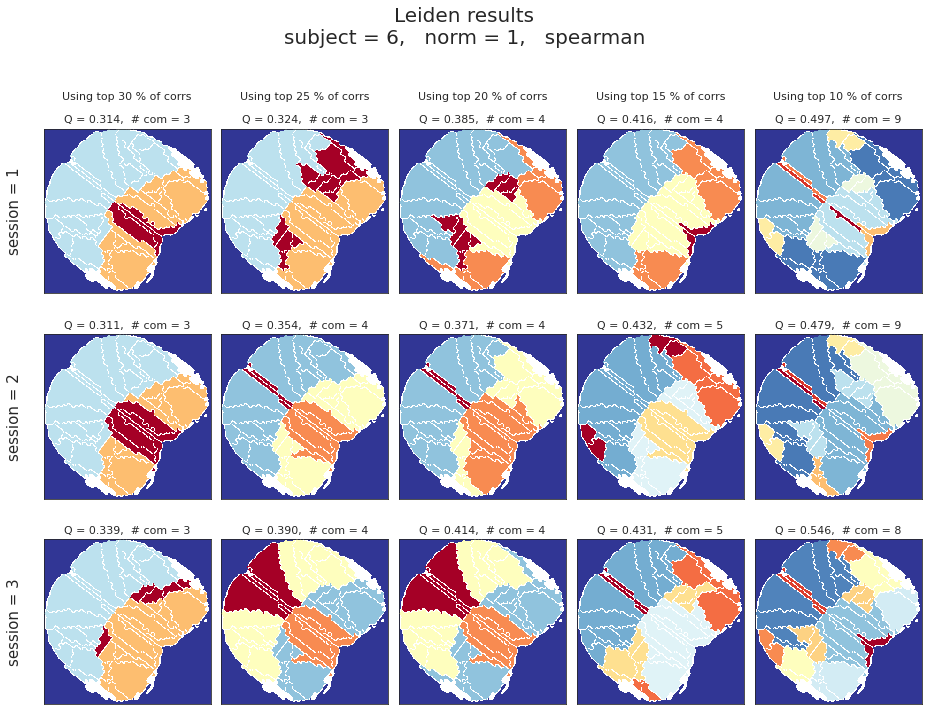

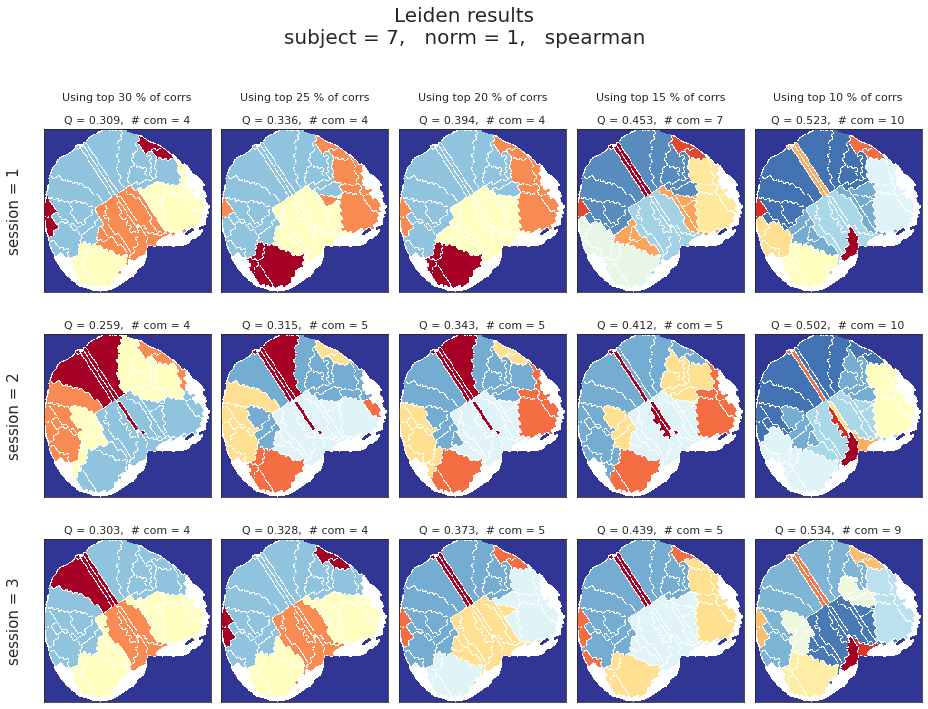

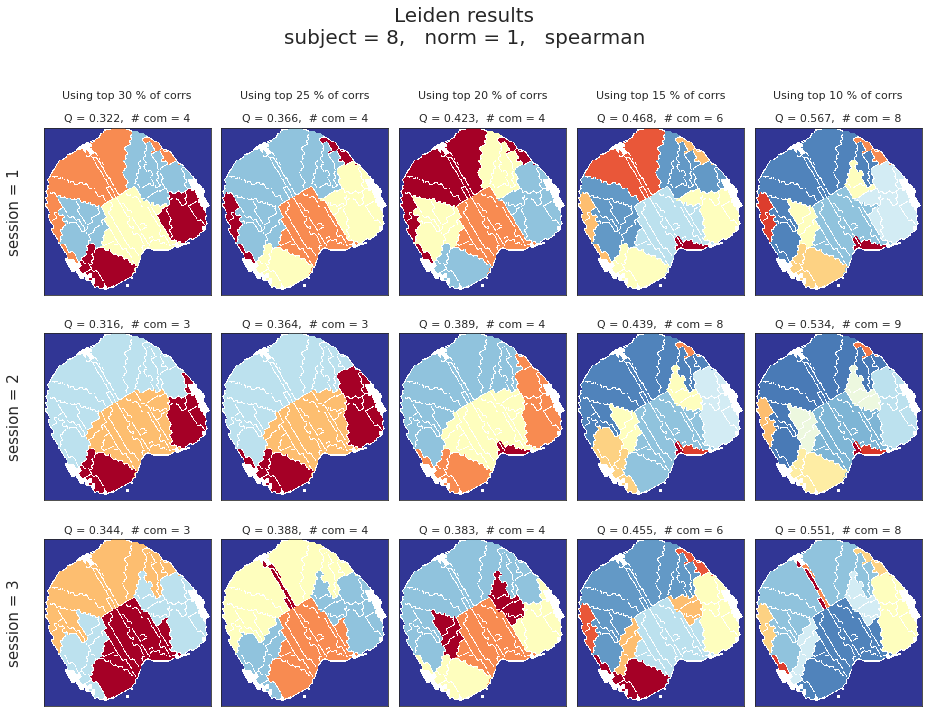

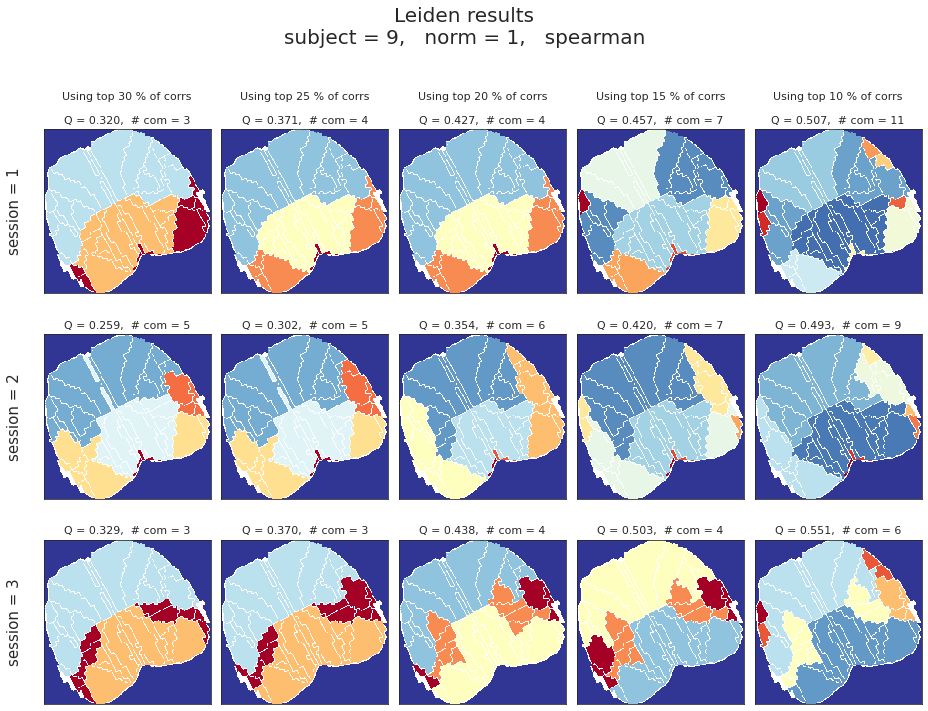

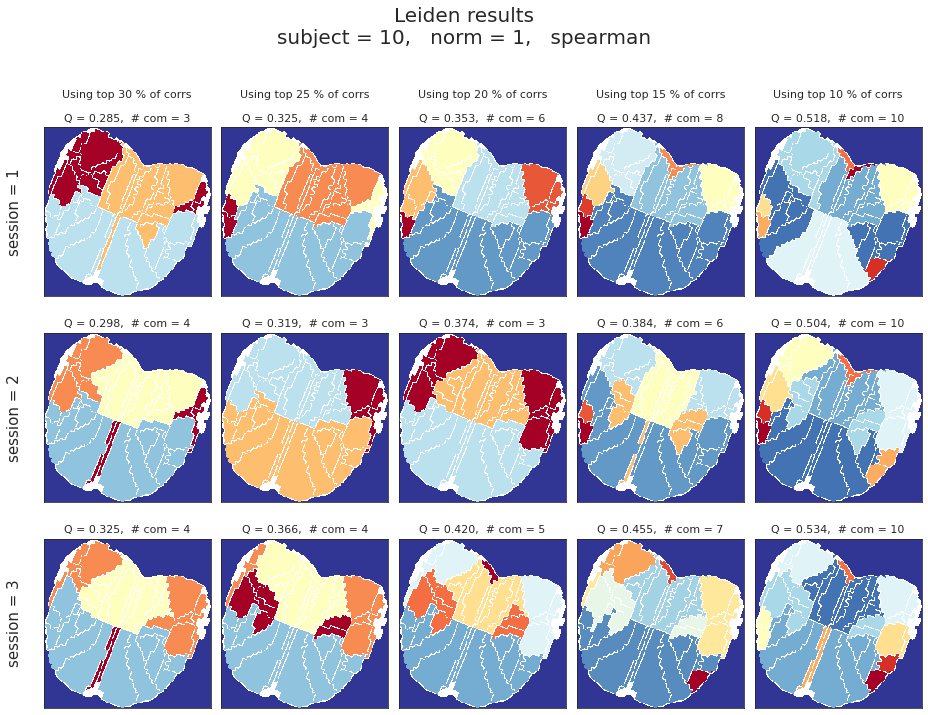

In [40]:
# HIDE CODE


config = Config()

for subject in range(1, config.num_subjects+1):
    session = 2
    run = 1

    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    sns.set_style('white')
    nrows, ncols = 3, len(percentiles)
    fig, axes = plt.subplots(nrows, ncols, figsize=(13, 10))
    axes = axes.reshape(nrows, ncols)

    for i, session in enumerate([1, 2, 3]):
        key = 'mode-{:s}_sub-SLC{:02d}_ses-{:d}_norm-{:s}'
        key = key.format(mode, subject, session, str(norm))
        for j, perc in enumerate(percentiles):
            tmp_key = '{:s}_perc-{:d}'.format(key, perc)
            try:
                data = graph_all[tmp_key]
            except KeyError:
                continue

            node_labels = data.node_labels
            g = data.g

            leiden_coms = cdlib_algorithms.leiden(g, weights='weight')
            leiden_community = leiden_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in leiden_community))
            leiden_partition = convert('community', 'partition', community=leiden_community)
            output = filter_islands(leiden_partition, atls_org['atlas'], node_labels, min_com_size=0)

            q = nx_comm.modularity(g, communities=leiden_community)

            if i == 0:
                msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
            else:
                msg = ''
            msg += 'Q = {:.3f},  # com = {:d}'
            msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

            data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
            im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
            axes[i, j].set_title(msg, fontsize=11)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if j == 0:
                axes[i, j].set_ylabel('session = {:d}\n'.format(session), fontsize=15)

    msg = 'Leiden results\nsubject = {:d},   norm = {:s},   spearman'
    sup = fig.suptitle(msg.format(subject, str(norm)), fontsize=20, y=1.02)
    fig.tight_layout()    
    plt.show()

    print('\n\n')

### Results: 10 x subjects

#### InfoMap

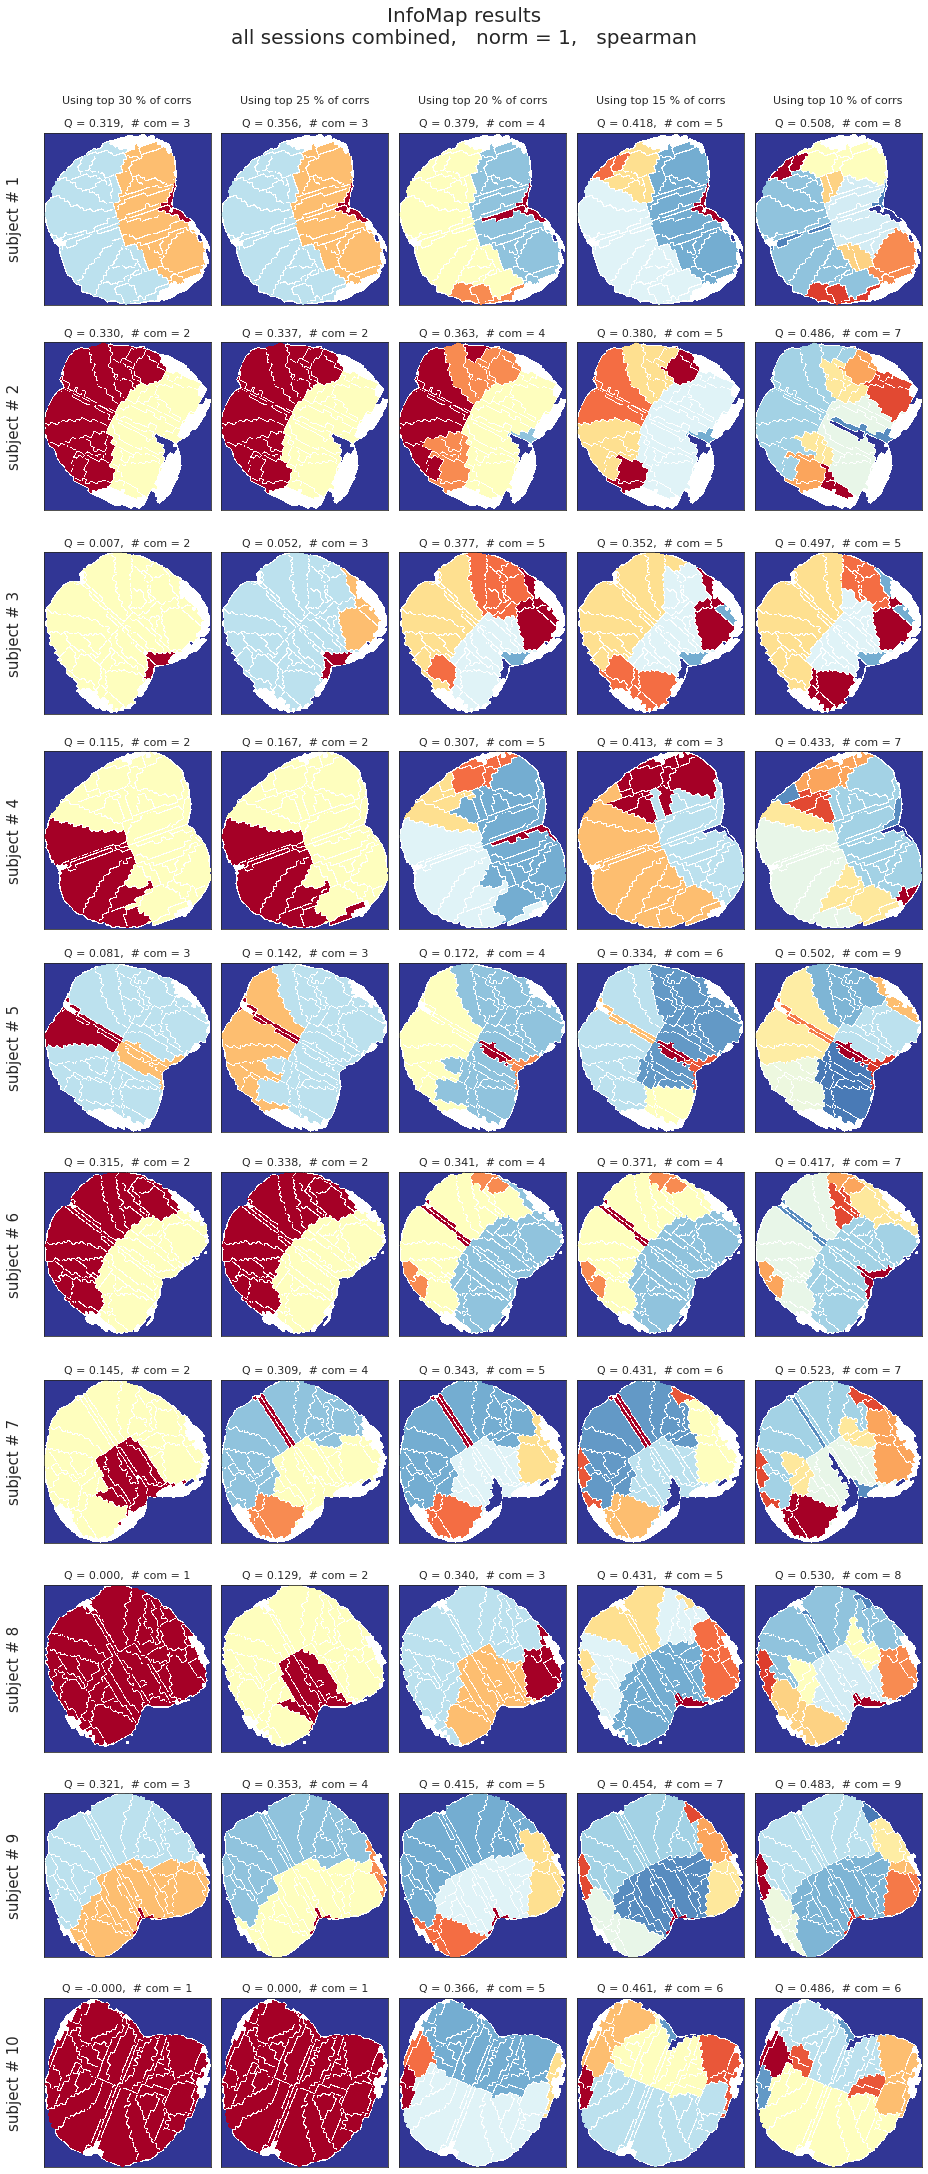

In [41]:
# HIDE CODE


config = Config()

sns.set_style('white')
nrows, ncols = config.num_subjects, len(percentiles)
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 30))
axes = axes.reshape(nrows, ncols)

for i, subject in enumerate(range(1, config.num_subjects+1)):
    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=2,
        run=1,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    key = 'mode-{:s}_sub-SLC{:02d}_norm-{:s}'
    key = key.format(mode, subject, str(norm))
    for j, perc in enumerate(percentiles):
        tmp_key = '{:s}_perc-{:d}'.format(key, perc)
        try:
            data = graph_all[tmp_key]
        except KeyError:
            continue

        node_labels = data.node_labels
        g = data.g

        infomap_coms = cdlib_algorithms.infomap(g)
        infomap_community = infomap_coms.communities
        _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
        infomap_partition = convert('community', 'partition', community=infomap_community)
        output = filter_islands(infomap_partition, atls_org['atlas'], node_labels, min_com_size=0)

        infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
        q = nx_comm.modularity(g, communities=infomap_community)

        if i == 0:
            msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

        data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
        im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
        axes[i, j].set_title(msg, fontsize=11)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if j == 0:
            axes[i, j].set_ylabel('subject # {:d}\n'.format(subject), fontsize=15)

msg = 'InfoMap results\nall sessions combined,   norm = {:s},   spearman'
sup = fig.suptitle(msg.format(str(norm)), fontsize=20, y=1.01)
fig.tight_layout()    
plt.show()

#### Leiden

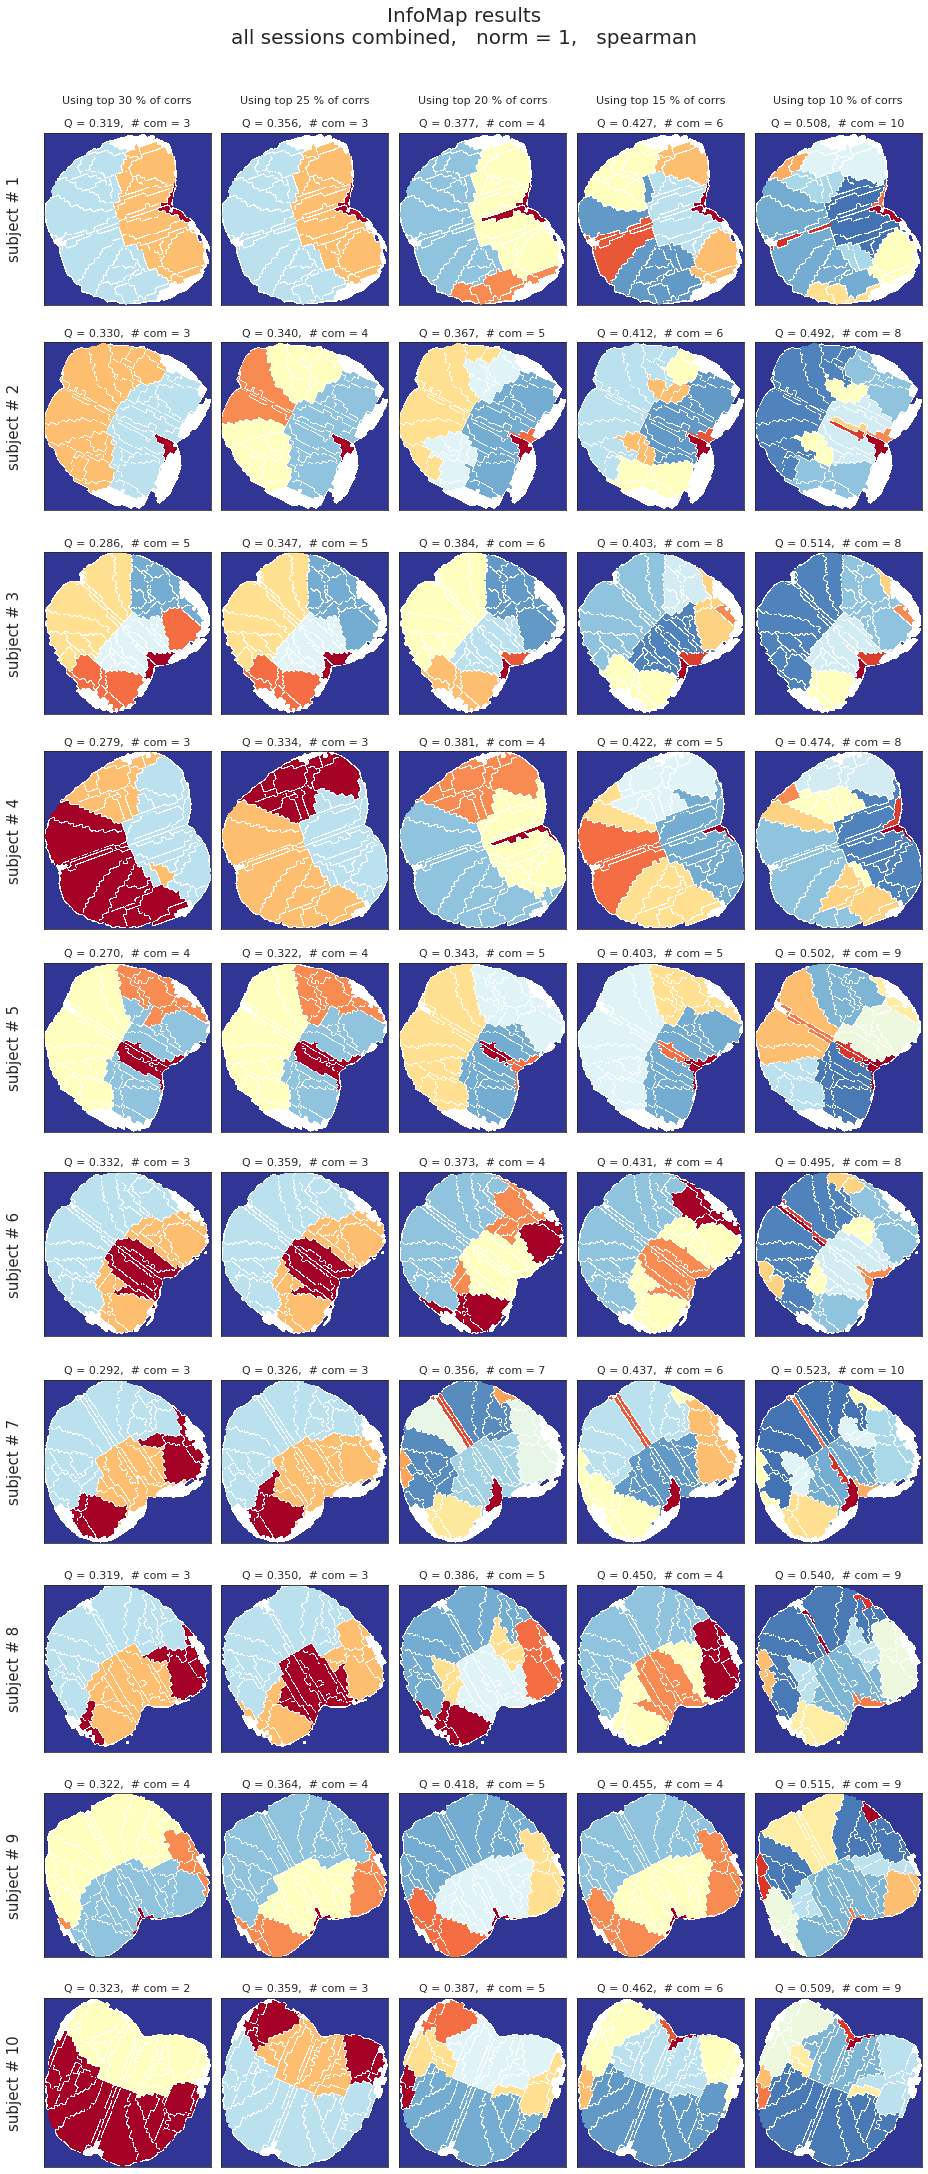

In [42]:
# HIDE CODE


config = Config()

sns.set_style('white')
nrows, ncols = config.num_subjects, len(percentiles)
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 30))
axes = axes.reshape(nrows, ncols)

for i, subject in enumerate(range(1, config.num_subjects+1)):
    load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=2,
        run=1,
    )
    atls_org = organize_atlas(load, include=common_regions)
    excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
    cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
    contour_refined = functools.reduce(np.logical_or, cond)

    key = 'mode-{:s}_sub-SLC{:02d}_norm-{:s}'
    key = key.format(mode, subject, str(norm))
    for j, perc in enumerate(percentiles):
        tmp_key = '{:s}_perc-{:d}'.format(key, perc)
        try:
            data = graph_all[tmp_key]
        except KeyError:
            continue

        node_labels = data.node_labels
        g = data.g

        leiden_coms = cdlib_algorithms.leiden(g, weights='weight')
        leiden_community = leiden_coms.communities
        _nodes_in_communities = set.union(*(set(x) for x in leiden_community))
        leiden_partition = convert('community', 'partition', community=leiden_community)
        output = filter_islands(leiden_partition, atls_org['atlas'], node_labels, min_com_size=0)

        q = nx_comm.modularity(g, communities=leiden_community)

        if i == 0:
            msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

        data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
        im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
        axes[i, j].set_title(msg, fontsize=11)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if j == 0:
            axes[i, j].set_ylabel('subject # {:d}\n'.format(subject), fontsize=15)

msg = 'InfoMap results\nall sessions combined,   norm = {:s},   spearman'
sup = fig.suptitle(msg.format(str(norm)), fontsize=20, y=1.01)
fig.tight_layout()    
plt.show()

### Results: global

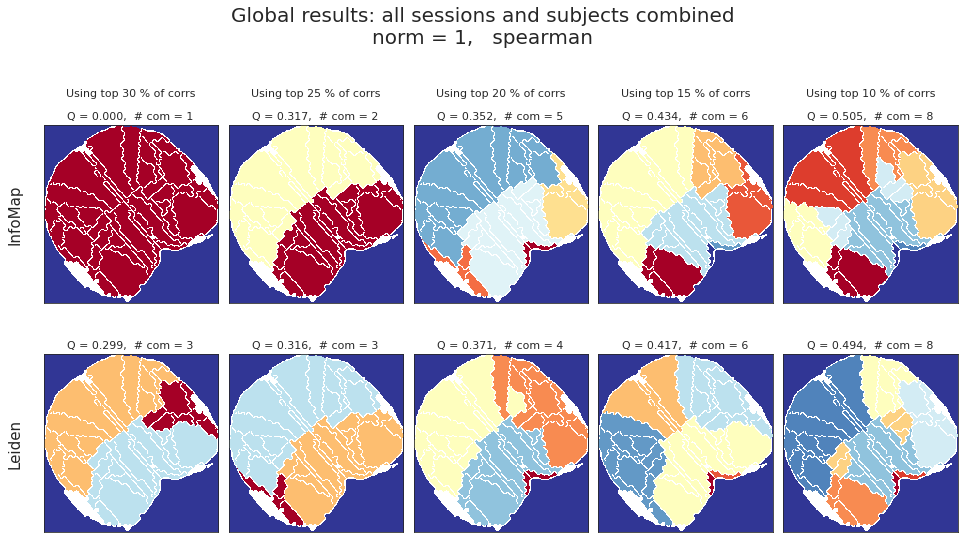

In [43]:
# HIDE CODE


config = Config()

sns.set_style('white')
nrows, ncols = 2, len(percentiles)
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8))
axes = axes.reshape(nrows, ncols)

load = load_organized_data(
    folder='atlas-allen_unfiltered_unnormalized',
    config=config,
    subject=6,
    session=1,
    run=1,
)
atls_org = organize_atlas(load, include=common_regions)
excluded_regions = [k for k in atls_org['regions'] if k not in common_regions]
cond = [atls_org['atlas'] == r for r in excluded_regions] + [atls_org['contour']]
contour_refined = functools.reduce(np.logical_or, cond)

key = 'mode-{:s}_norm-{:s}'
key = key.format(mode, str(norm))
for j, perc in enumerate(percentiles):
    tmp_key = '{:s}_perc-{:d}'.format(key, perc)
    try:
        data = graph_all[tmp_key]
    except KeyError:
        continue

    node_labels = data.node_labels
    g = data.g

    for i in range(2):
        if i == 0:
            infomap_coms = cdlib_algorithms.infomap(g)
            infomap_community = infomap_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in infomap_community))
            infomap_partition = convert('community', 'partition', community=infomap_community)
            output = filter_islands(infomap_partition, atls_org['atlas'], node_labels, min_com_size=0)

            infomap_community.append([node for node in g.nodes if node not in _nodes_in_communities])
            q = nx_comm.modularity(g, communities=infomap_community)
        else:
            leiden_coms = cdlib_algorithms.leiden(g, weights='weight')
            leiden_community = leiden_coms.communities
            _nodes_in_communities = set.union(*(set(x) for x in leiden_community))
            leiden_partition = convert('community', 'partition', community=leiden_community)
            output = filter_islands(leiden_partition, atls_org['atlas'], node_labels, min_com_size=0)

            q = nx_comm.modularity(g, communities=leiden_community)

        if i == 0:
            msg = 'Using top {:d} {:s} of corrs\n\n'.format(perc, '%')
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

        data2plt = np.ma.masked_where(contour_refined, output['comm_mat'])
        im = axes[i, j].imshow(data2plt, cmap='RdYlBu_r', interpolation='none')
        axes[i, j].set_title(msg, fontsize=11)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        if j == 0:
            axes[0, j].set_ylabel('InfoMap\n', fontsize=15)
            axes[1, j].set_ylabel('Leiden\n', fontsize=15)

msg = 'Global results: all sessions and subjects combined\nnorm = {:s},   spearman'
sup = fig.suptitle(msg.format(str(norm)), fontsize=20, y=1.01)
fig.tight_layout()    
plt.show()

## Network measures

In [45]:
# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length

### ...coming next

In [ ]:
measures_df = pd.DataFrame()

dict_list = []
for k in tqdm(data_all.keys()):
    for normalized in [True, False]:
        data = data_all_n[k] if normalized else data_all[k]
    
        # the real graph
        real_avg_clustering = average_clustering(data.graph, weight='weight')
        real_local_efficiency = local_efficiency(data.graph)
        real_large_clique_ratio = large_clique_size(data.graph) / len(common_regions)
        try:
            real_avg_shortest_path_len = average_shortest_path_length(data.graph, weight='weight')
        except:
            real_avg_shortest_path_len = np.nan
        real_global_efficiency = global_efficiency(data.graph)
        real_degree_corr_coef = degree_pearson_correlation_coefficient(data.graph, weight='weight')

        data_dict = {
            'tag': ['-'.join(['real', 'n' if normalized else ''])] * 6,
            'subject': [data.subject] * 6,
            'session': [data.session] * 6,
            'percentile': [data.percentile] * 6,
            'lbl': [
                'avg_clustering',
                'local_efficiency',
                'large_clique_ratio',
                'avg_shortest_path_len',
                'global_efficiency',
                'degree_corr_coef',
            ],
            'val': [
                real_avg_clustering,
                real_local_efficiency,
                real_large_clique_ratio,
                real_avg_shortest_path_len,
                real_global_efficiency,
                real_degree_corr_coef,
            ],
        }
        dict_list.append(data_dict)

        # configuration model
        cfg_avg_clustering = average_clustering(data.cfg, weight='weight')
        cfg_local_efficiency = local_efficiency(data.cfg)
        cfg_large_clique_ratio = large_clique_size(data.cfg) / len(common_regions)
        try:
            cfg_avg_shortest_path_len = average_shortest_path_length(data.cfg, weight='weight')
        except:
            cfg_avg_shortest_path_len = np.nan
        cfg_global_efficiency = global_efficiency(data.cfg)
        cfg_degree_corr_coef = degree_pearson_correlation_coefficient(data.cfg, weight='weight')

        data_dict = {
            'tag': ['-'.join(['cfg', 'n' if normalized else ''])] * 6,
            'subject': [data.subject] * 6,
            'session': [data.session] * 6,
            'percentile': [data.percentile] * 6,
            'lbl': [
                'avg_clustering',
                'local_efficiency',
                'large_clique_ratio',
                'avg_shortest_path_len',
                'global_efficiency',
                'degree_corr_coef',
            ],
            'val': [
                cfg_avg_clustering,
                cfg_local_efficiency,
                cfg_large_clique_ratio,
                cfg_avg_shortest_path_len,
                cfg_global_efficiency,
                cfg_degree_corr_coef,
            ],
        }
        dict_list.append(data_dict)
        
        data_dict = {
            'tag': ['-'.join(['ratio', 'n' if normalized else ''])] * 6,
            'subject': [data.subject] * 6,
            'session': [data.session] * 6,
            'percentile': [data.percentile] * 6,
            'lbl': [
                'avg_clustering',
                'local_efficiency',
                'large_clique_ratio',
                'avg_shortest_path_len',
                'global_efficiency',
                'degree_corr_coef',
            ],
            'val': [
                real_avg_clustering / cfg_avg_clustering,
                real_local_efficiency / cfg_local_efficiency,
                real_large_clique_ratio / cfg_large_clique_ratio,
                real_avg_shortest_path_len / cfg_avg_shortest_path_len,
                real_global_efficiency / cfg_global_efficiency,
                real_degree_corr_coef / cfg_degree_corr_coef,
            ],
        }
        dict_list.append(data_dict)

measures_df = pd.DataFrame.from_dict(merge_dicts(dict_list))

In [12]:
measures_df

tag  subject  session  percentile                    lbl        val
0     real-n        1        1          25         avg_clustering   0.644256
1     real-n        1        1          25       local_efficiency   0.846707
2     real-n        1        1          25     large_clique_ratio   0.227273
3     real-n        1        1          25  avg_shortest_path_len   1.928298
4     real-n        1        1          25      global_efficiency   0.563020
...      ...      ...      ...         ...                    ...        ...
4315  ratio-       10        3          10       local_efficiency   3.708654
4316  ratio-       10        3          10     large_clique_ratio   2.333333
4317  ratio-       10        3          10  avg_shortest_path_len        NaN
4318  ratio-       10        3          10      global_efficiency   0.723041
4319  ratio-       10        3          10       degree_corr_coef -10.055066

[4320 rows x 6 columns]

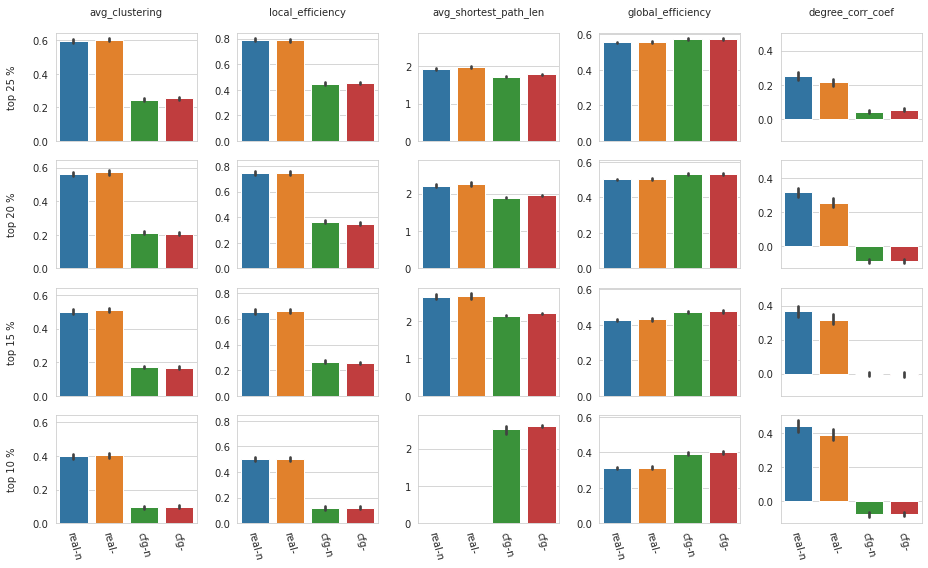

In [13]:
_perc = measures_df.percentile.unique().tolist()
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item != 'large_clique_ratio']
_tags = ['real-n', 'real-', 'cfg-n', 'cfg-']

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=len(_perc), ncols=len(_lbls), figsize=(13, 8), sharey='col', sharex='all')

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag.isin(_tags)) &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl)
        ]
        sns.barplot(
            data=selected_df,
            y='val',
            x='tag',
            hue='tag',
            order=_tags,
            hue_order=_tags,
            dodge=False,
            ax=axes[i, j],
        )
        axes[i, j].legend().set_visible(False)
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=10)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=10)
        else:
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(axis='x', rotation=-75)

fig.tight_layout()
fig.savefig('net_measures.pdf', dpi=300)
plt.show()

In [14]:
normalized = True
perc = 25
data = data_global_n[perc] if normalized else data_global[k]

# the real graph
global_avg_clustering = average_clustering(data.graph, weight='weight')
global_local_efficiency = local_efficiency(data.graph)
global_large_clique_ratio = large_clique_size(data.graph) / len(common_regions)
try:
    global_avg_shortest_path_len = average_shortest_path_length(data.graph, weight='weight')
except:
    global_avg_shortest_path_len = np.nan
global_global_efficiency = global_efficiency(data.graph)
global_degree_corr_coef = degree_pearson_correlation_coefficient(data.graph, weight='weight')

print(global_avg_clustering, global_local_efficiency, global_avg_shortest_path_len, global_degree_corr_coef)

# configuration model
global_cfg_avg_clustering = average_clustering(data.cfg, weight='weight')
global_cfg_local_efficiency = local_efficiency(data.cfg)
global_cfg_large_clique_ratio = large_clique_size(data.cfg) / len(common_regions)
try:
    global_cfg_avg_shortest_path_len = average_shortest_path_length(data.cfg, weight='weight')
except:
    global_cfg_avg_shortest_path_len = np.nan
global_cfg_global_efficiency = global_efficiency(data.cfg)
global_cfg_degree_corr_coef = degree_pearson_correlation_coefficient(data.cfg, weight='weight')

print(global_cfg_avg_clustering, global_cfg_local_efficiency, global_cfg_avg_shortest_path_len, global_cfg_degree_corr_coef)

0.5898890357886829 0.8062715870431183 1.8074813926478634 0.2637708998060512
0.25587019629498436 0.4625099733772861 1.6679558945481336 0.0246764094027035


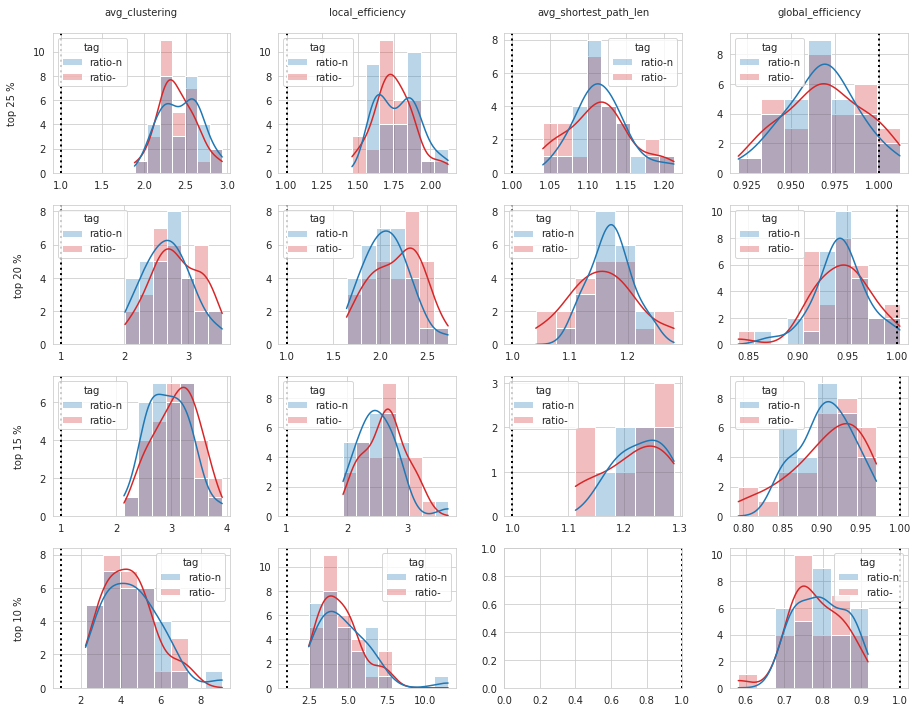

In [15]:
_perc = measures_df.percentile.unique().tolist()
_lbls = measures_df.lbl.unique().tolist()
_lbls = [item for item in _lbls if item not in ['large_clique_ratio', 'degree_corr_coef']]
_tags = ['ratio-n', 'ratio-']

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=len(_perc), ncols=len(_lbls), figsize=(13, 10))

for i, perc in enumerate(_perc):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[
            (measures_df.tag.isin(_tags)) &
            (measures_df.percentile == perc) &
            (measures_df.lbl == lbl)
        ]
        sns.histplot(
            data=selected_df,
            x='val',
            hue='tag',
            hue_order=_tags,
            palette=['C0', 'C3'],
            legend=True,
            kde=True,
            alpha=0.3,
            ax=axes[i, j],
        )
        axes[i, j].axvline(1, ls=':', lw=2, color='k')
        # axes[i, j].legend().set_visible(False)
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=10)
            
        if j == 0:
            axes[i, j].set_ylabel('top {:d} {:s}\n'.format(perc, '%'), fontsize=10)
        else:
            axes[i, j].set_ylabel('')
            
        axes[i, j].tick_params(axis='x', rotation=0)

fig.tight_layout()
fig.savefig('net_measures_ratio.pdf', dpi=300)
plt.show()

### Degree centrality

In [32]:
centralities = {}
centralities_cfg = {}

for perc, data in data_global_n.items():
    # real
    g = data.graph
    degree = nx.degree_centrality(g)
    closeness = nx.closeness_centrality(g, distance='weight')
    harmonic = nx.harmonic_centrality(g, distance='weight')
    betweenness = nx.betweenness_centrality(g, weight='weight')
    try:
        information = nx.information_centrality(g, weight='weight')
    except:
        information = {}
    eigenvector = nx.eigenvector_centrality(g, weight='weight')
    katz = nx.katz_centrality_numpy(g, weight='weight')
    centralities[perc] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        'harmonic': {k: v/max(list(harmonic.values())) for k, v in harmonic.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'information': information,
        'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
        'katz': katz,
    }

    # cfg
    g = data.cfg
    degree = nx.degree_centrality(g)
    closeness = nx.closeness_centrality(g, distance='weight')
    harmonic = nx.harmonic_centrality(g, distance='weight')
    betweenness = nx.betweenness_centrality(g, weight='weight')
    try:
        information = nx.information_centrality(g, weight='weight')
    except:
        information = {}
    eigenvector = nx.eigenvector_centrality(g, weight='weight')
    katz = nx.katz_centrality_numpy(g, weight='weight')
    centralities_cfg[perc] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        'harmonic': {k: v/max(list(harmonic.values())) for k, v in harmonic.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'information': information,
        'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
        'katz': katz,
    }

In [33]:
percentile = 15

centralities_cortex = {}
for lbl, centrality_d in centralities[percentile].items():
    x = np.ones(load['atlas'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas'] == region_id] = value
    centralities_cortex[lbl] = x

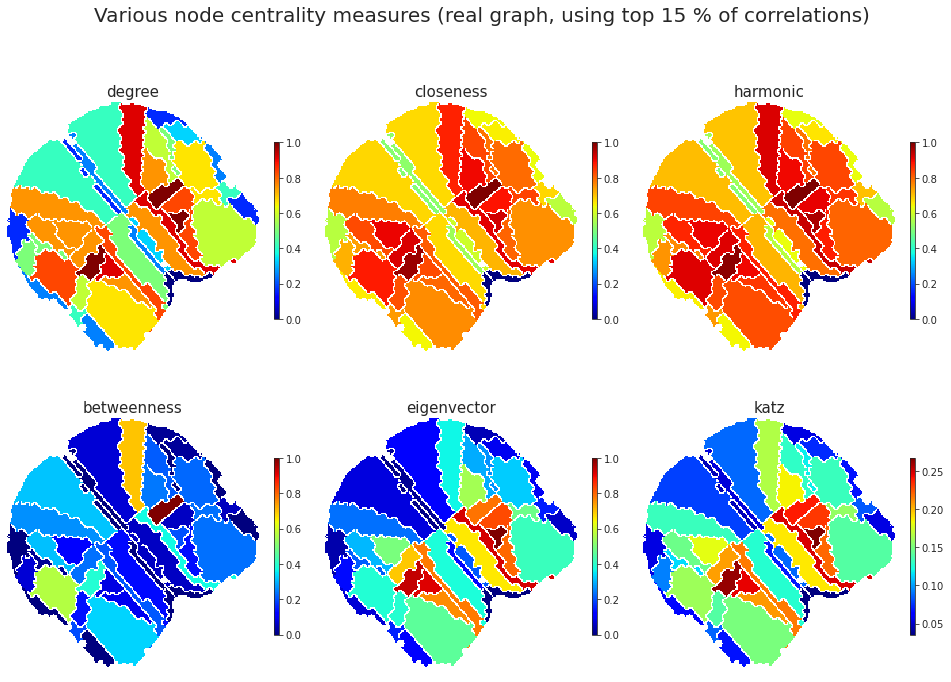

In [34]:
sns.set_style('white')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 10))

for idx, (lbl, x) in enumerate(centralities_cortex.items()):
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(np.ma.masked_where(atls_org['contour'], x), cmap='jet', interpolation='none')
    axes[i, j].set_title(lbl, fontsize=15)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)

msg = 'Various node centrality measures (real graph, using top {:d} {:s} of correlations)'
fig.suptitle(msg.format(percentile, '%'), fontsize=20, y=1.01)
fig.tight_layout()
plt.show()

In [35]:
percentile = 15

centralities_cortex = {}
for lbl, centrality_d in centralities_cfg[percentile].items():
    x = np.ones(load['atlas'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas'] == region_id] = value
    centralities_cortex[lbl] = x

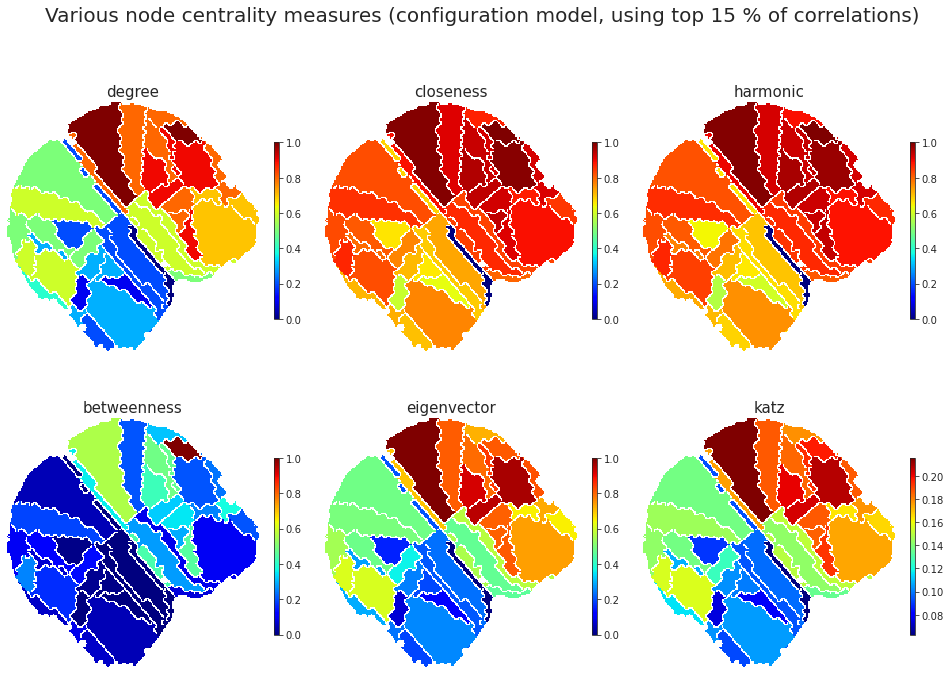

In [36]:
sns.set_style('white')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 10))

for idx, (lbl, x) in enumerate(centralities_cortex.items()):
    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(np.ma.masked_where(atls_org['contour'], x), cmap='jet', interpolation='none')
    axes[i, j].set_title(lbl, fontsize=15)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)

msg = 'Various node centrality measures (configuration model, using top {:d} {:s} of correlations)'
fig.suptitle(msg.format(percentile, '%'), fontsize=20, y=1.01)
fig.tight_layout()
plt.show()